# 0.0 IMPORTS

In [1]:
import os
import math

import numpy as np
import pandas as pd
import random
import pickle
import seaborn as sns
import xgboost as xgb
import warnings
import inflection

from flask                    import Flask
from scipy                    import stats as ss
from boruta                   import BorutaPy
from tabulate                 import tabulate
from matplotlib               import pyplot as plt

from sklearn.metrics          import mean_absolute_error, mean_squared_error
from IPython.display          import Image
from sklearn.ensemble         import RandomForestRegressor
from IPython.core.display     import HTML
from sklearn.linear_model     import LinearRegression, Lasso
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 Helper Functions

In [2]:
warnings.filterwarnings("ignore")

def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range (1, kfold+1) ):

        if verbose:
            print( 'Kfold número: {}'.format(k) )

        start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        training = x_training[x_training['date'] < start_date]
        validating = x_training[( x_training['date'] >= start_date ) & (x_training['date'] <= end_date ) ]

        xtraining = training.drop( columns = ['date', 'sales'], axis = 1)
        xvalidating = validating.drop( columns = ['date', 'sales'], axis = 1)

        ytraining = training['sales']
        yvalidating = validating['sales']

        ml = model.fit(xtraining, ytraining)

        y_hat = ml.predict(xvalidating)

        ml_result = ml_error( 'model_name', np.expm1(yvalidating) , np.expm1(y_hat) )

        mae_list.append( ml_result['MAE'] )
        mape_list.append( ml_result['MAPE'] )
        rmse_list.append( ml_result['RMSE'] )


    results = pd.DataFrame( {' Model' : model_name, 
                             'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ), 
                             'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ), 
                             'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index = [0])
    return results

def mean_absolute_percentage_error( y, y_hat ):
    return np.mean( np.abs ( y - y_hat ) / y)*100

def mean_percentage_error( y, y_hat ):
    return  np.mean ( ( y - y_hat ) / y) * 100

def root_mean_squared_error( y, y_hat ):
    return np.sqrt( mean_squared_error (y, y_hat) )

def ml_error(model_name, y, y_hat):
    mae = mean_absolute_error( y, y_hat )
    mape = mean_absolute_percentage_error( y, y_hat ) 
    rmse = root_mean_squared_error( y, y_hat )
    return pd.DataFrame( { 'Model': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse }, index = [0] )

def cramer( a1, a2 ):    
    cm = pd.crosstab( a1, a2 ).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    k, r = cm.shape
    phi = chi2 / n
    v = np.sqrt ( phi / (min (k-1, r-1) ) )
    phi_ap = max( 0, phi - (k-1) * (r-1) / (n-1) ) 
    k1 = k - ( ( k - 1)**2 ) / (n - 1)
    r1 = r - ( ( r - 1)**2 ) / (n - 1)
    v_corr = np.sqrt( (phi_ap) / min( k1-1, r1-1 ) )
    
    return v_corr

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False) 
df_store_raw = pd.read_csv('data/store.csv', low_memory = False) 

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

**Column Description:**
    
Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in 
February, May, August, November of any given year for that store

In [5]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 STEP 01 - DATA DESCRIPTION

In [6]:
df1 = df_raw.copy()

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Column Renaming

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [9]:
print(' Rows count: {}'.format( df1.shape[0]))
print(' Columns count: {}'.format( df1.shape[1]))

 Rows count: 1017209
 Columns count: 18


## 1.3 Data Types

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
#converting 'date' from object to datetime
df1['date'] = pd.to_datetime(df1['date']) 

## 1.4 NA Checking

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 NA Filling

In [13]:
#competition_distance: lack of information must mean lack of competition (either real or relevant). Initial idea: filling NA's with high distances.
#Highest real distance on DataFrame: 75km. Fill NA's with: 200km.

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month and competition_open_since_year: lack of information must mean lack of competition (either real or relevant). 
#Initial idea: filling with the same date as 'sales' feature for eliminating NA's purposes only.

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'] , axis = 1) 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'] , axis = 1) 

#promo2_since_week and promo2_since_year: lack of data must mean lack of promotion.
#Initial idea: filling with the same date as 'sales' feature for eliminating NA's purposes only.

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'] , axis = 1) 
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'] , axis = 1) 

#promo_interval: lack of data must mean lack of promotion.
#Initial idea: check sale day with promo_interval and add binary feature to tell if there was an ongoing promotion at the time. 

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1.apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis = 1 )

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Data Types Checking

In [15]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype ( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype ( 'int64' )
df1['promo2_since_week'] = df1['promo2_since_week'].astype ( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype ( 'int64' )


In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistics

In [17]:
num_att = df1.select_dtypes( include = (int64, float64))
cat_att = df1.select_dtypes( exclude = (int64, float64, datetime64) )

### 1.7.1 Numerical Data

In [18]:
#Central tendency metrics: mean and median

#mmean

ct1 = num_att.apply( lambda x: np.mean(x))

#median
ct2 = num_att.apply( lambda x: np.median(x))

In [19]:
#dispersion metrics: min, max, range, standard deviation, skew and kurtosis

#min
d1 = num_att.apply( lambda x: min(x))

#max
d2 = num_att.apply( lambda x: max(x))

#range
d3 = num_att.apply( lambda x: max(x)- min(x))

#std
d4 = num_att.apply( lambda x: std(x))

#skew
d5 = num_att.apply( lambda x: x.skew() )

#kurtosis
d6 = num_att.apply( lambda x: x.kurtosis() )


num_df = pd.DataFrame( [ d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
num_df.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [20]:
num_df

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

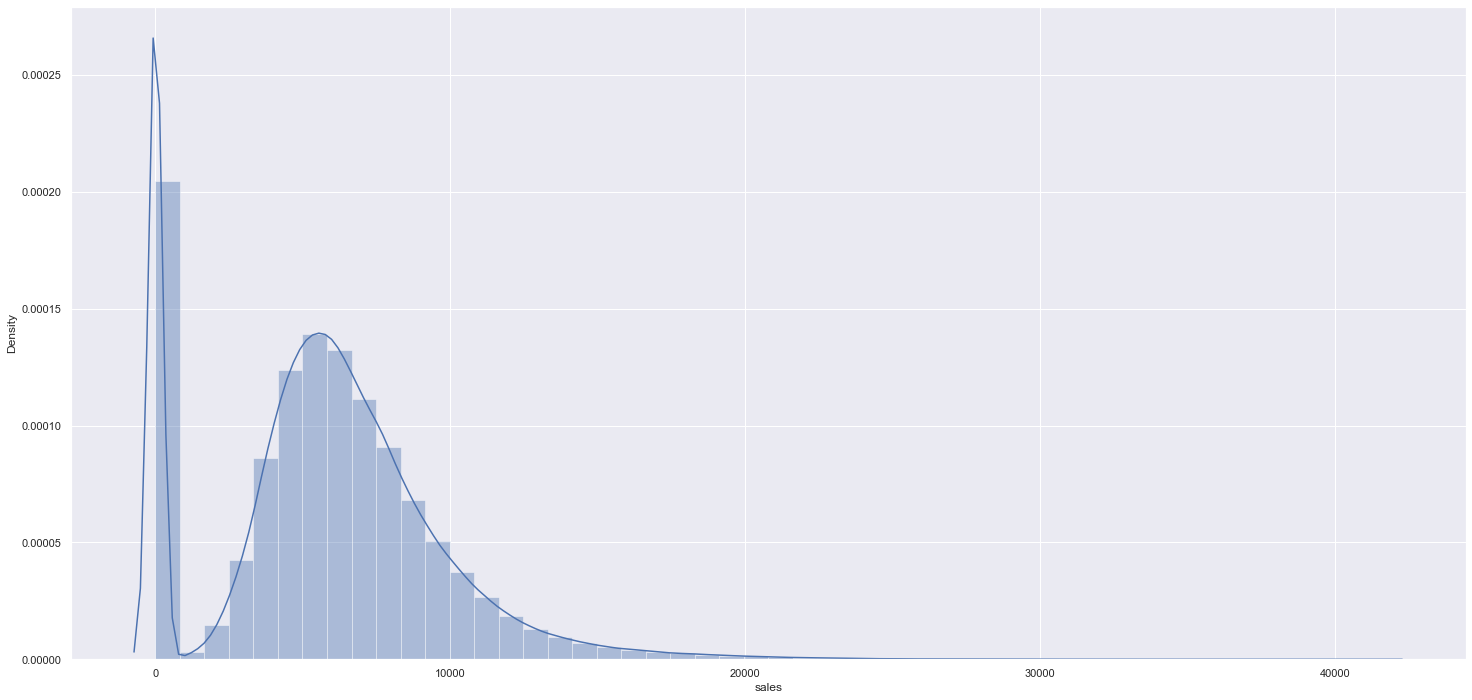

In [21]:
sns.distplot( df1['sales'] )

<AxesSubplot:xlabel='competition_distance'>

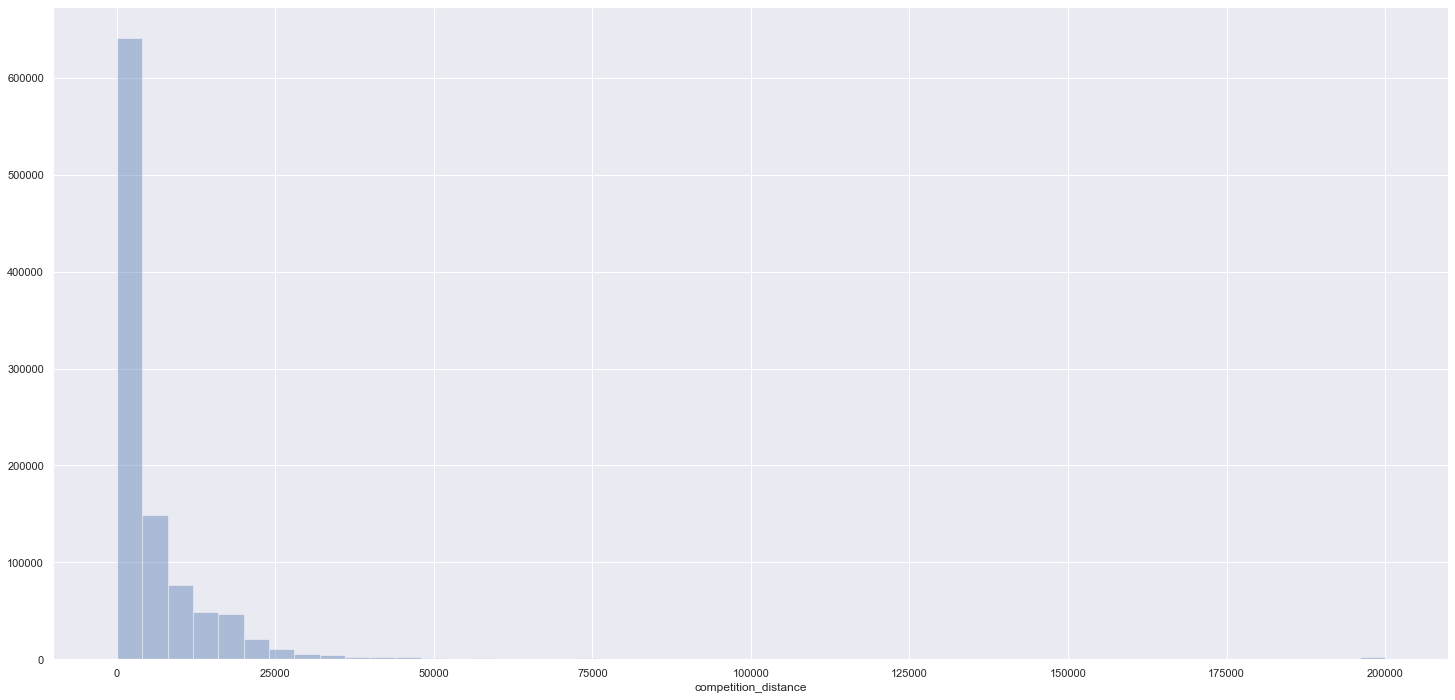

In [22]:
sns.distplot( df1['competition_distance'], kde = False )

### 1.7.2 Categorical Data

In [23]:
cat_att.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

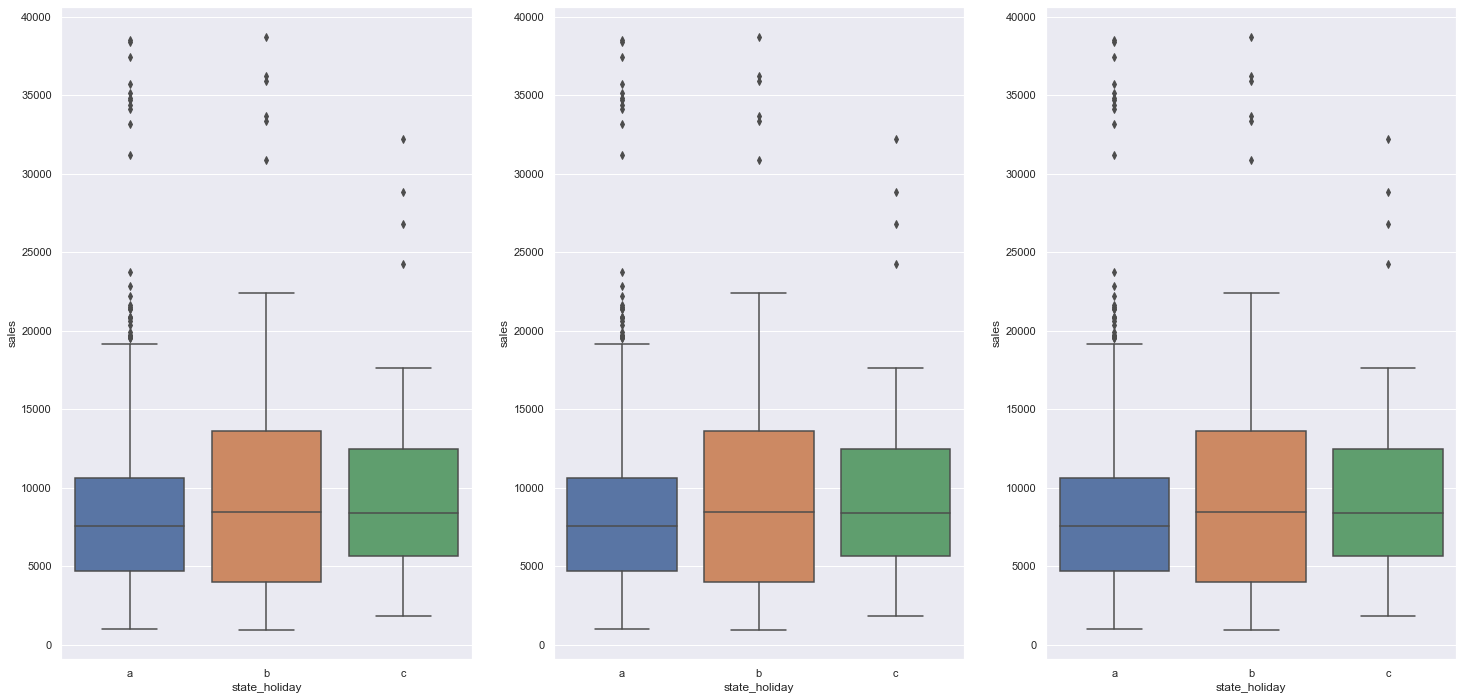

In [24]:
# state_holiday
plt.subplot( 1, 3, 1 )
aux1 = df1[ ( (df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ) ] 
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

# type
#aux1 = df1[ ( (df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ) ] 
plt.subplot( 1, 3, 2 )
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

# assortment
plt.subplot( 1, 3, 3 )
#aux1 = df1[ ( (df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ) ] 
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

# 2.0 STEP 02 - FEATURE ENGINEERING

In [25]:
df2 = df1.copy()

## 2.1 Hypotheses Mind Map

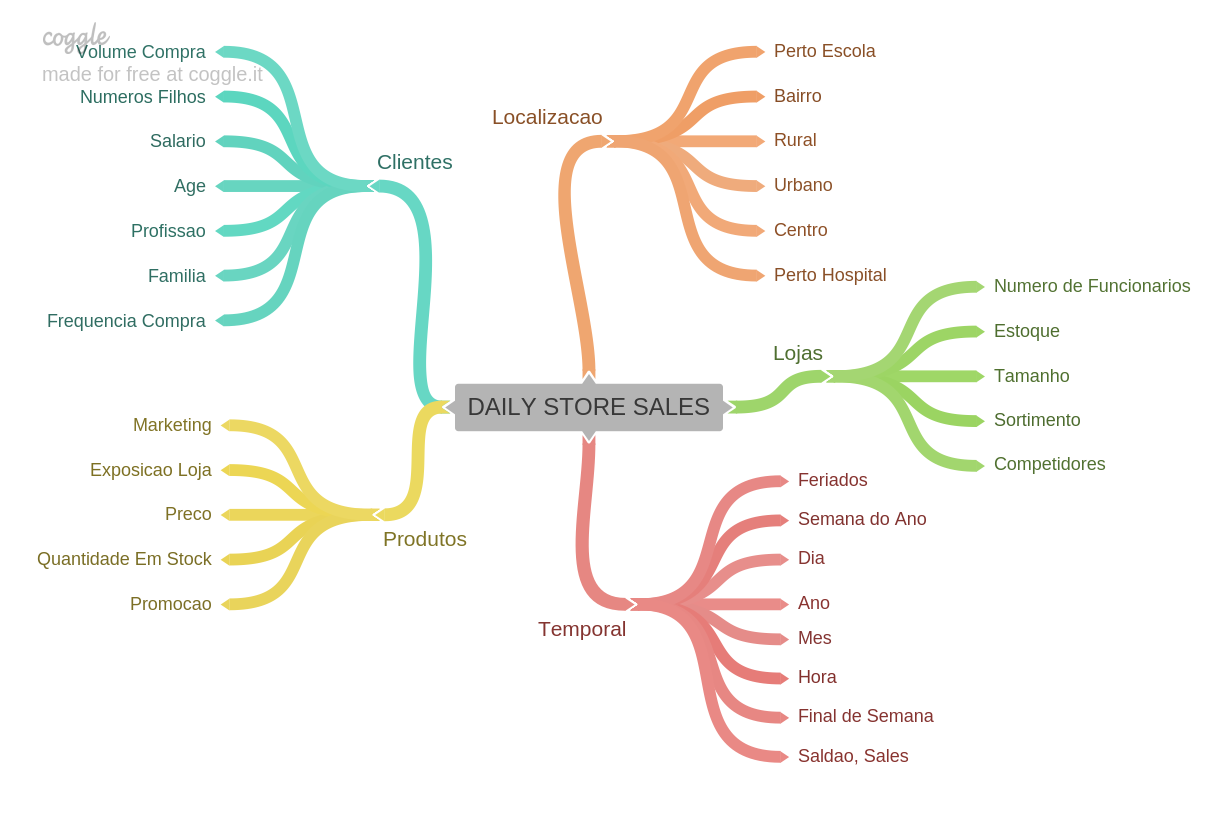

In [26]:
Image( 'img/MindMapHypothesis.png' )

## 2.2 Hypotheses Creation

### 2.2.1 Store Hypotheses

**1.** Stores with higher number of employees should sell more.

**2.** Stores with greater inventories should sell more.

**3.** Larger stores should sell more.

**4.** Stores with greater variety of items should sell more.

**5.** Stores whose competitors are closer should sell less.

**6.** Stores whose competitors are opened for a longer period should sell more.

### 2.2.2 Product Hypotheses

**1.** Stores that invest more in marketing should sell more.

**2.** Stores with greater product exposure should sell more.

**3.** Stores with lower prices should sell more.

**4.** Stores with more aggressive promotions (bigger discounts) should sell more.

**5.** Stores with ongoing promotions for longer periods should sell more.

**6.** Stores with more promotional days overall should sell more.

**7.** Store with consecutive promotions should sell more.

### 2.2.3 Time Hypotheses

**1.** Stores opened on Christmas Holiday should sell more.

**2.** Stores should sell more as years go by.

**3.** Stores should sell more on the second semester of the year.

**4.** Stores should sell more after the 10th day of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less on school holidays.

## 2.3 Final Hypotheses List

**1.** Stores with greater inventories should sell more.

**2.** Stores whose competitors are closer should sell less.

**3.** Stores whose competitors are opened for a longer period should sell more.

**4.** Stores with ongoing promotions for longer periods should sell more.

**5.** Stores with more promotional days overall should sell more.

**6.** Stores with consecutive promotions should sell more.

**7.** Stores open on Christmas Holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second semester of each year.

**10.** Stores should sell more after the 10th day of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less on school holidays.

## 2.4 Feature Engineering

In [27]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since - creating competition_time_month: amount of months since competition started.
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int64 )

# promo since - creating promo_time_week: amount of weeks since promotion started.
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int64 )

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'Public' if x == 'a' else 'Easter' if x == 'b' else 'Christmas' if x == 'c' else 'None' )


In [28]:
df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
821292,323,2,2013-06-25,4950,501,1,0,None,0,d,extended,8400.0,4,2012,1,5,2013,"Feb,May,Aug,Nov",Jun,0,2013,6,25,26,2013-25,2012-04-01,15,2013-01-28,21
136238,209,2,2015-03-31,9427,683,1,1,None,0,a,extended,11680.0,9,2011,1,31,2013,"Jan,Apr,Jul,Oct",Mar,0,2015,3,31,14,2015-13,2011-09-01,43,2013-07-29,87
645696,897,6,2013-11-30,4711,550,1,0,None,0,c,extended,3290.0,1,2007,1,5,2013,"Feb,May,Aug,Nov",Nov,1,2013,11,30,48,2013-47,2007-01-01,84,2013-01-28,43
477893,344,2,2014-04-29,11045,1343,1,1,None,1,a,extended,300.0,4,2011,1,14,2011,"Jan,Apr,Jul,Oct",Apr,1,2014,4,29,18,2014-17,2011-04-01,37,2011-03-28,161
919585,496,5,2013-03-29,0,0,0,1,Easter,1,d,extended,2780.0,6,2015,0,13,2013,0,Mar,0,2013,3,29,13,2013-12,2015-06-01,-27,2013-03-25,0


# 3.0 STEP 03 - FEATURE FILTERING

In [29]:
df3 = df2.copy()

## 3.1 Row Selection

In [30]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2 Column Selection

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

In [32]:
df3 = df3.drop( cols_drop, axis = 1 )

In [33]:
df3.shape

(844338, 25)

# 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [34]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Target feature

<AxesSubplot:xlabel='sales', ylabel='Density'>

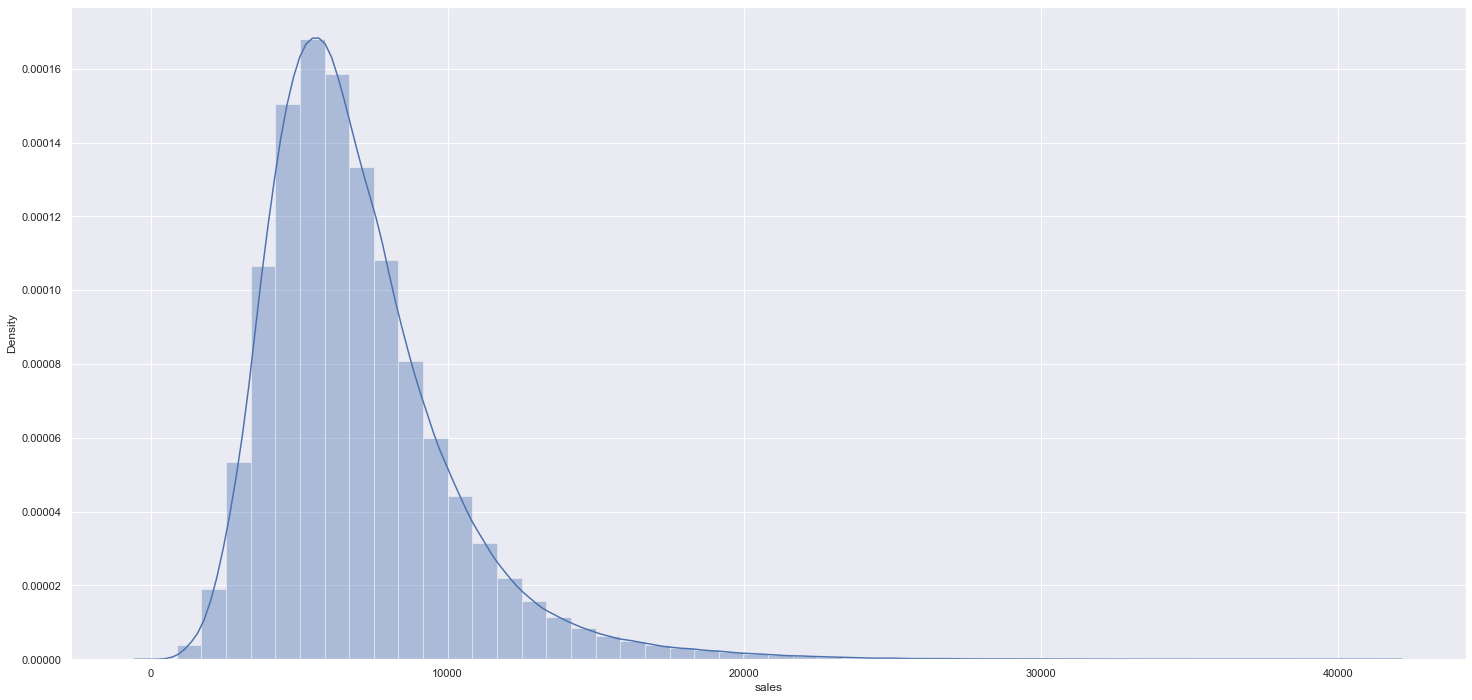

In [35]:
sns.distplot( df4['sales'] )

### 4.1.2 Numerical features

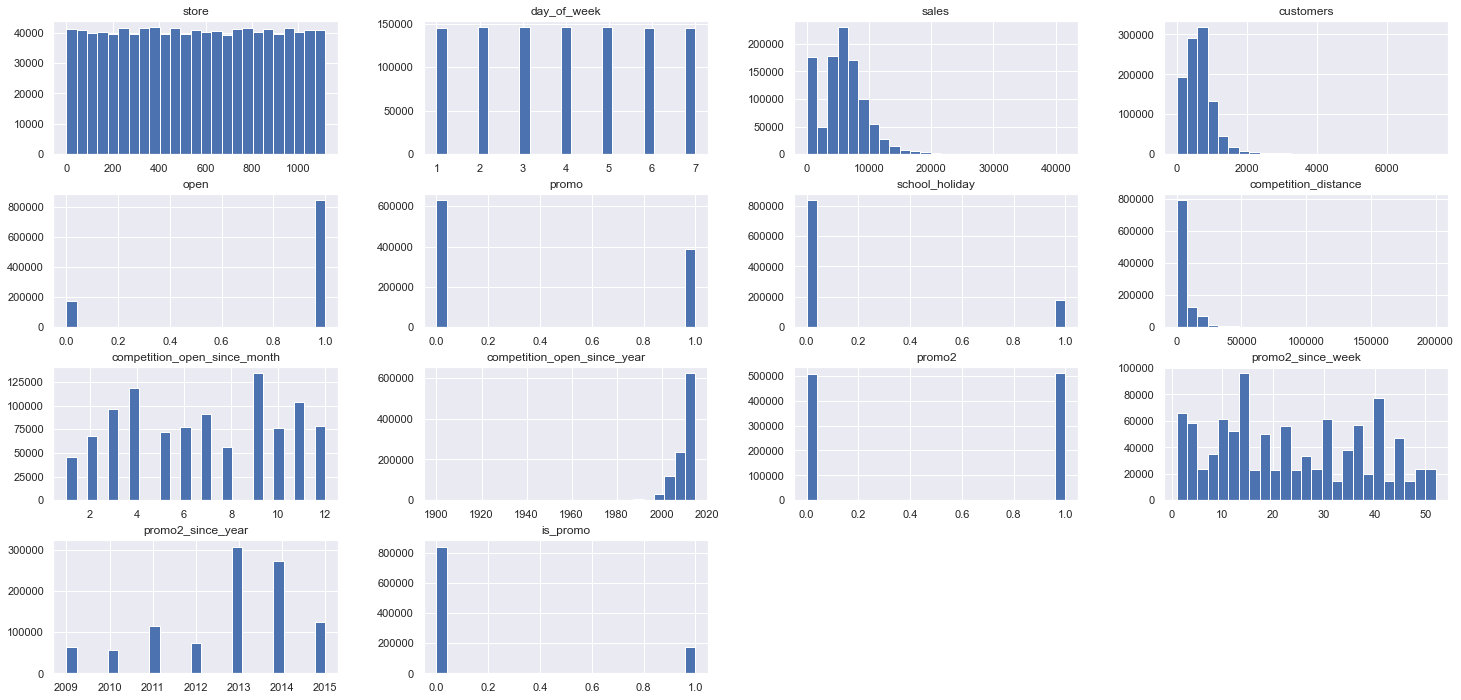

In [36]:
num_att.hist(bins = 25);

### 4.1.3 Categorical features

In [37]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

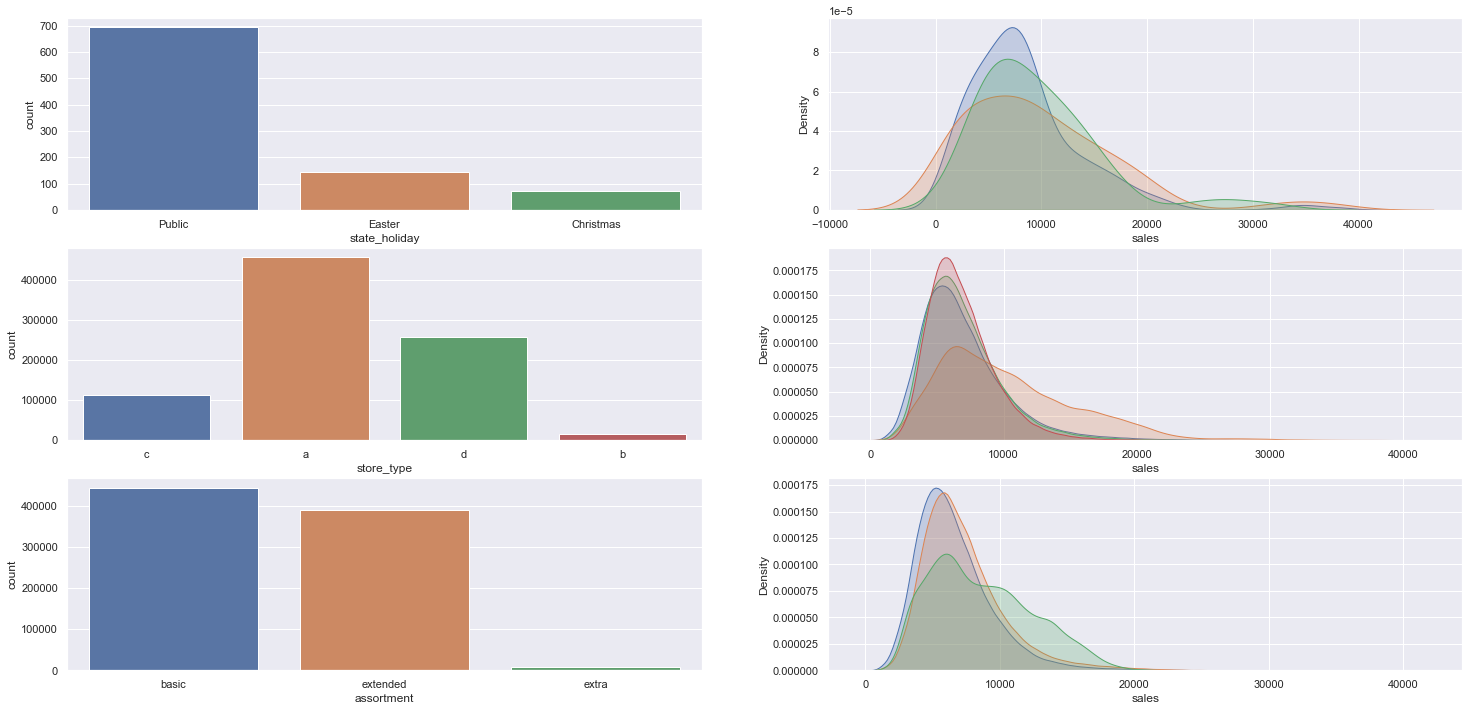

In [38]:
#state holiday

plt.subplot (3, 2, 1)
aux = df4 [ df4['state_holiday'] != 'None' ]
sns.countplot( aux['state_holiday']  )

plt.subplot (3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'Public']['sales'], label = 'Public', shade = True, legend = True )
sns.kdeplot(df4[df4['state_holiday'] == 'Easter']['sales'], label = 'Easter', shade = True, legend = True )
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label = 'Christmas', shade = True, legend = True )

#store type
plt.subplot (3, 2, 3)
sns.countplot( df4['store_type']  )

plt.subplot (3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True, legend = True )
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True, legend = True )
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True, legend = True )
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True, legend = True )

#assortment
plt.subplot (3, 2, 5)
sns.countplot( df4['assortment']  )

plt.subplot (3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True, legend = True )
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True, legend = True )
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True, legend = True )


## 4.2 Bivariate Analysis

### **H1.** **1.** Stores with greater inventories should sell more.
**FALSE** - Stores with greater inventories (considering the following as ascending order: basic < extended < extra) sell LESS.

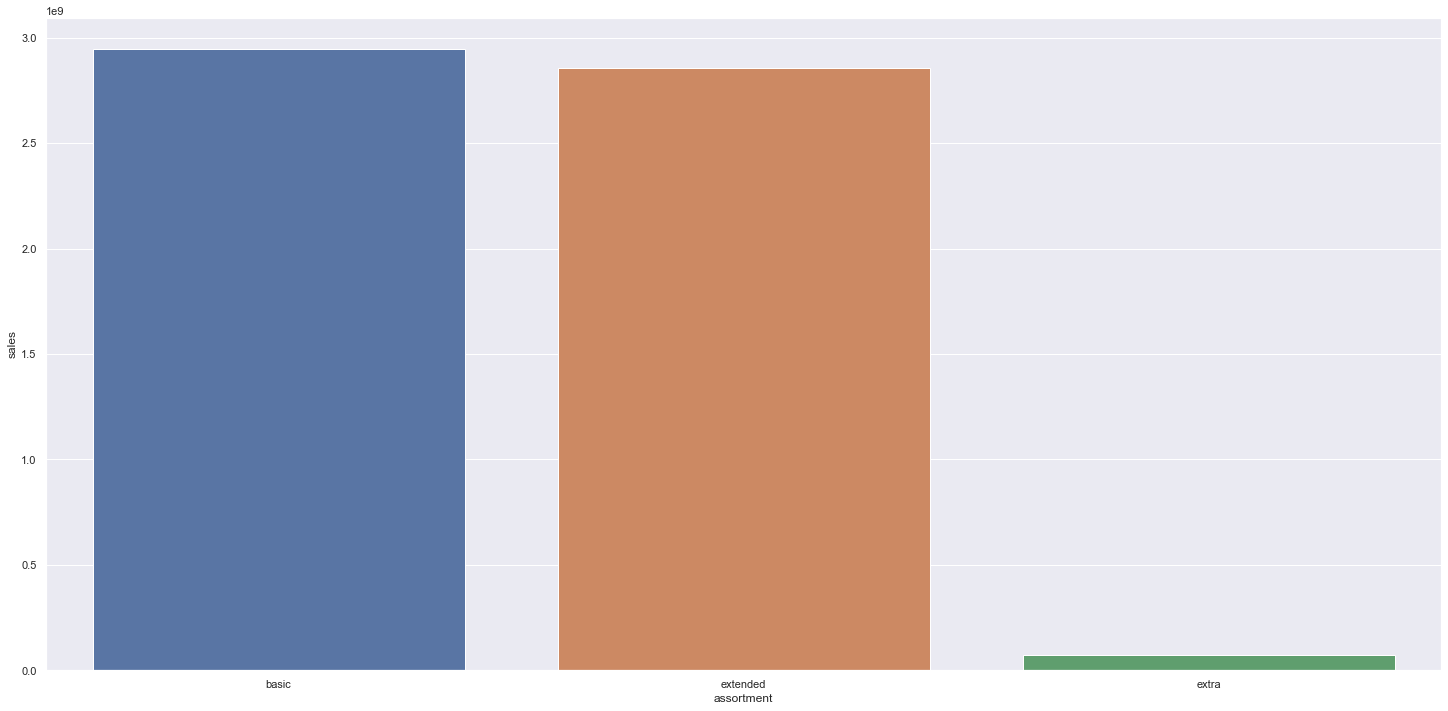

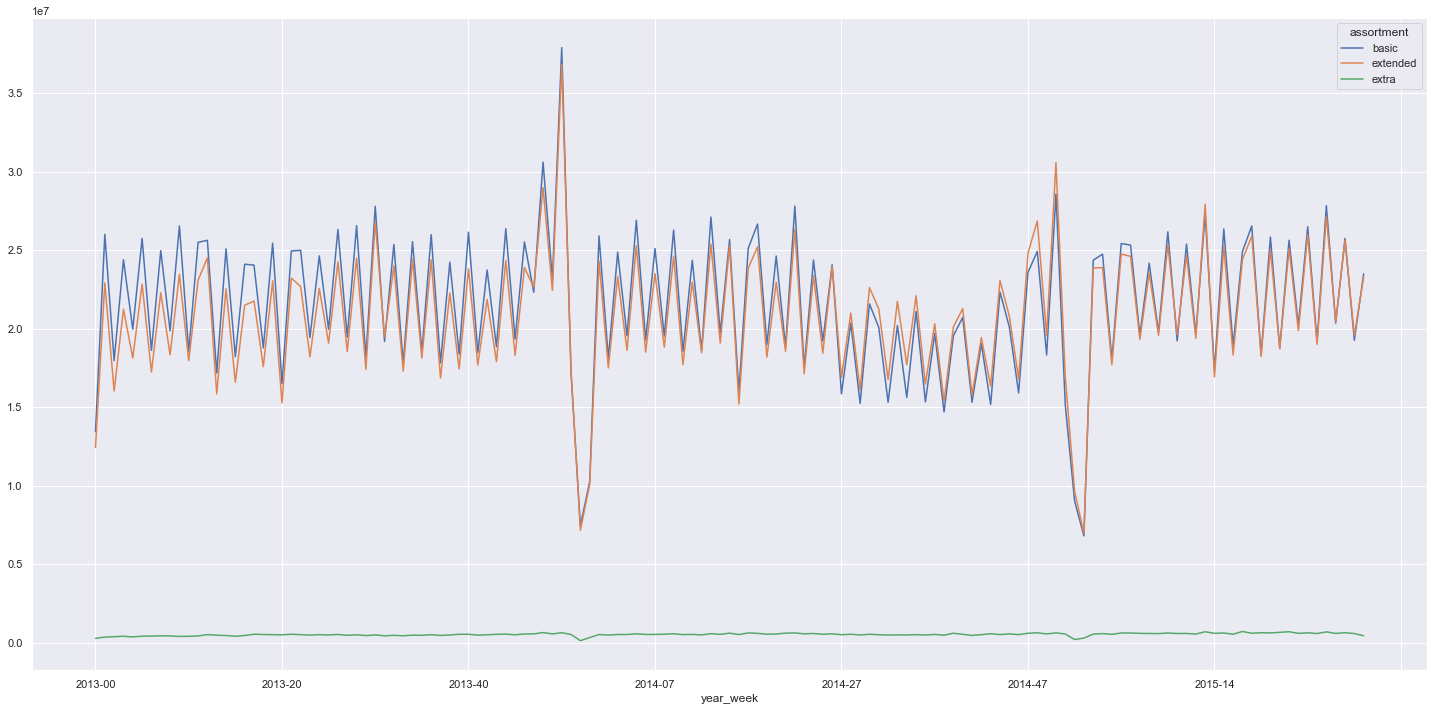

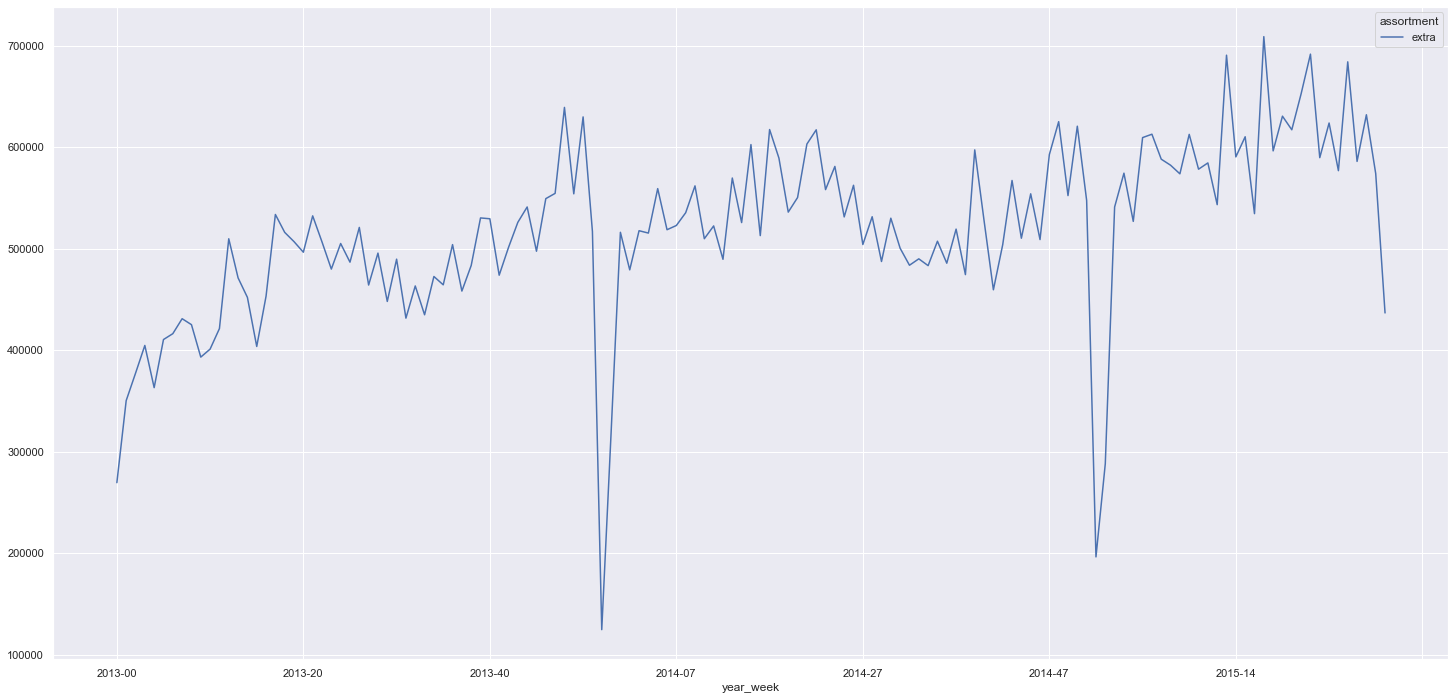

In [39]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['assortment', 'year_week','sales']].groupby(['assortment','year_week']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

### **H2.** Stores whose competitors are closer should sell less.
**FALSE** - Stores whose competitors are closer sell more.

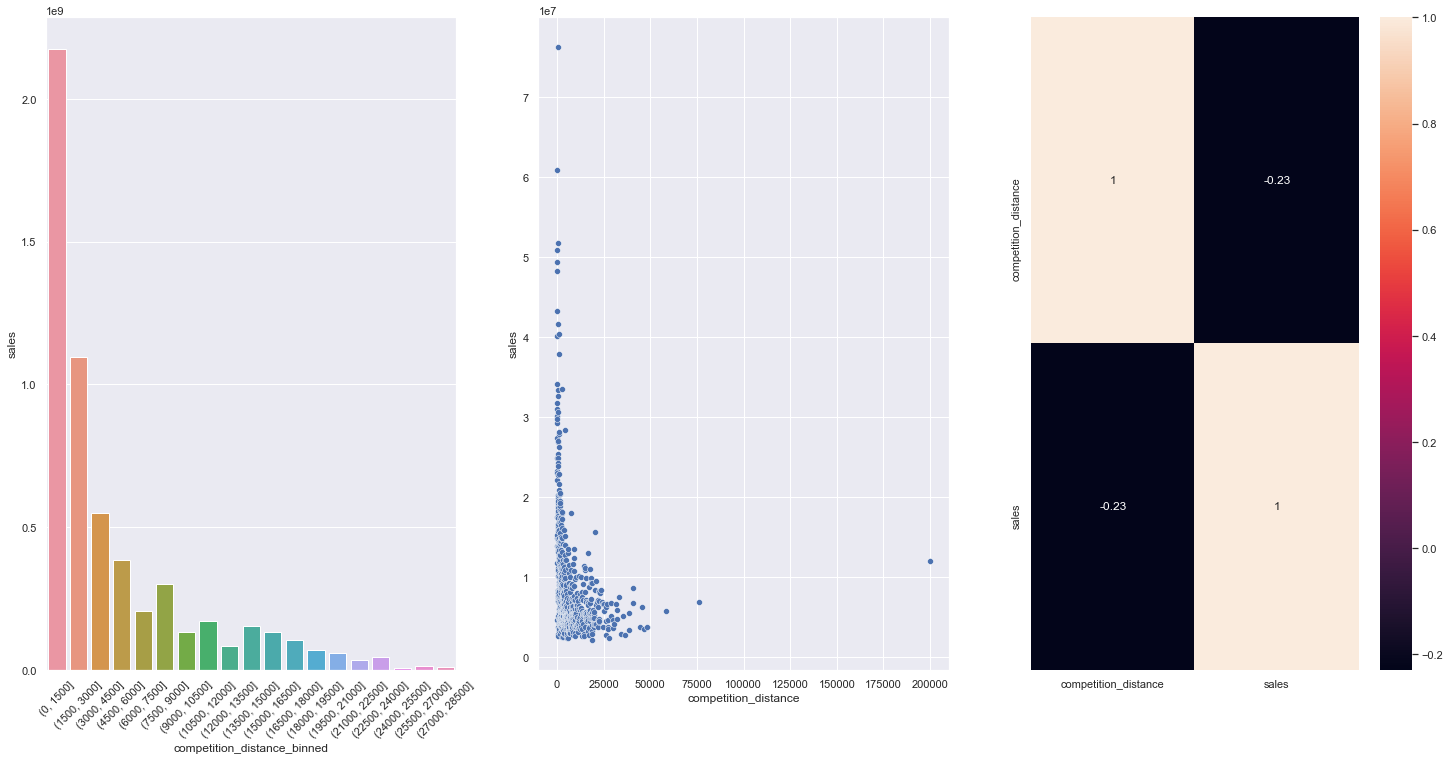

In [40]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
#sns.barplot(x = 'competition_distance', y = 'sales', data = aux1)

bins = np.arange(0, 30000, 1500)
aux1['competition_distance_binned'] = pd.cut(df4['competition_distance'], bins = bins)

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 45);

plt.subplot(1, 3, 2)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True);

### **H3.** Stores whose competitors are opened for a longer period should sell more.

**FALSE** - Stores whose competitors are opened for a longer period sell less.

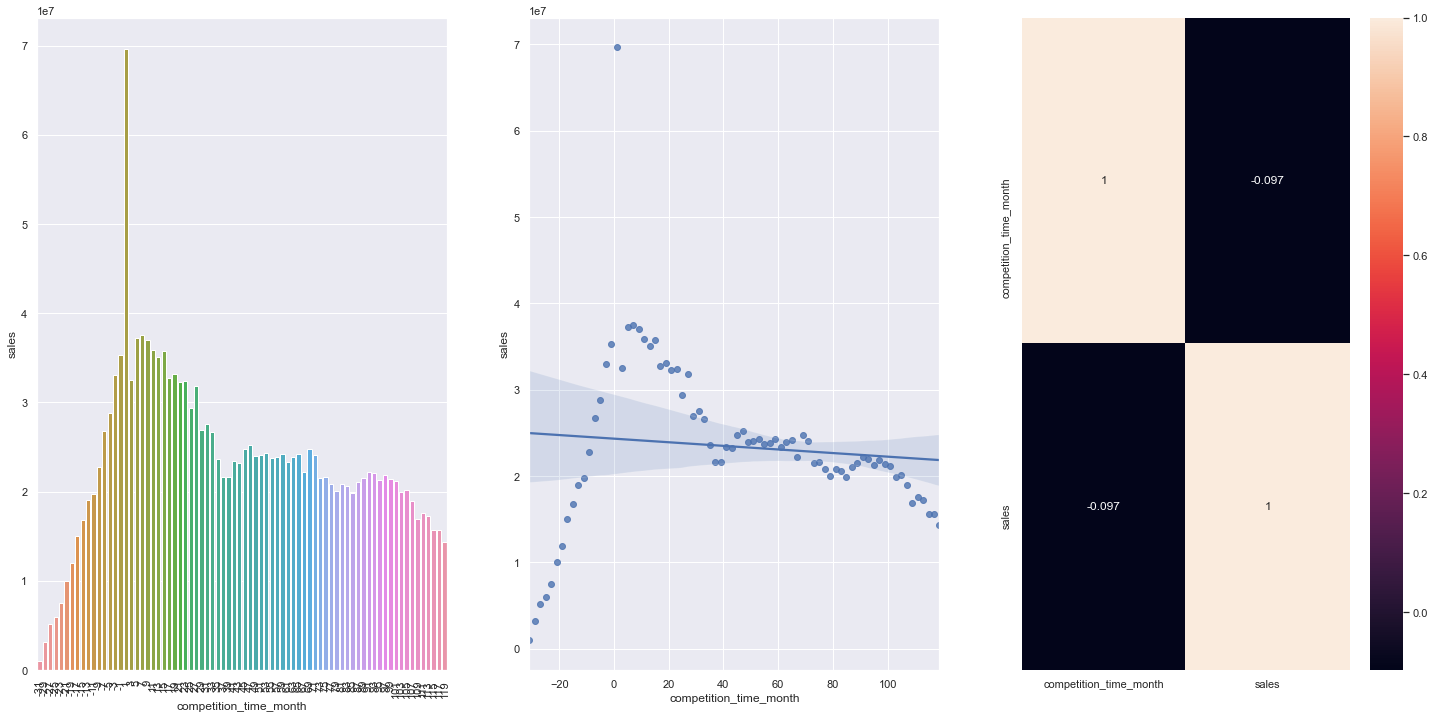

In [41]:
#problems noticed with data: there are competitors with opening dates in 1900 and 1961

aux1 = df4[(df4['competition_time_month'] < 120) & df4['competition_time_month'] != 0]
aux1 = aux1[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot( x = 'competition_time_month', y = 'sales', data = aux1);
plt.xticks(rotation = 90)

plt.subplot(1, 3, 2)
sns.regplot( x = 'competition_time_month', y = 'sales', data = aux1);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

### **H4.** Stores with ongoing promotions for longer periods should sell more.
**FALSE** - There's no such relationship. After a certain amount of promotion time sales start going down.

In [42]:
df4['promo_time_week'].describe()

count    844338.000000
mean         54.400699
std          85.457559
min        -126.000000
25%           0.000000
50%           0.000000
75%         109.000000
max         313.000000
Name: promo_time_week, dtype: float64

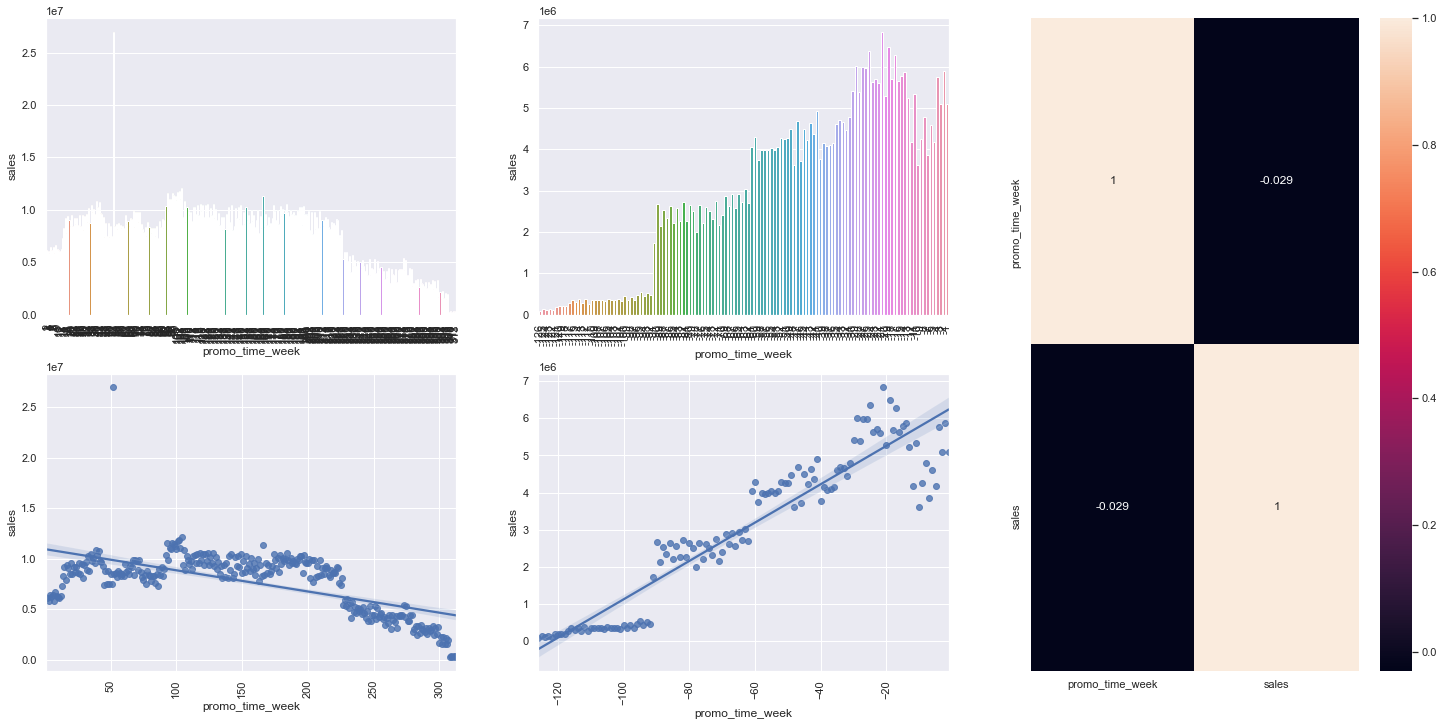

In [43]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec( 2 , 3 )

plt.subplot( grid[ 0 , 0] )
aux2 = aux1[ aux1['promo_time_week'] > 0 ]
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot( grid[ 0 , 1] )
aux3 = aux1[ aux1['promo_time_week'] < 0 ] 
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot( grid[ 1 , 0] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot( grid[ 1 , 1] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot( grid[ : , 2] )
sns.heatmap ( aux1.corr( method = 'pearson' ) , annot = True);


### <s> **H5.** Stores with more promotional days overall should sell more. </s> 

Hipothesis very similar to the previous one. It will be analyzed on a future CRISP cycle.

### **H6.** Stores with consecutive promotions should sell more.
**FALSE** - Stores with consecutive promotions sell less.

In [44]:
aux1 = df4[ ['promo', 'promo2', 'year_week', 'sales'] ].groupby( ['promo', 'promo2'] ).sum().reset_index()

In [45]:
aux1.sort_values( by = 'sales' )

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


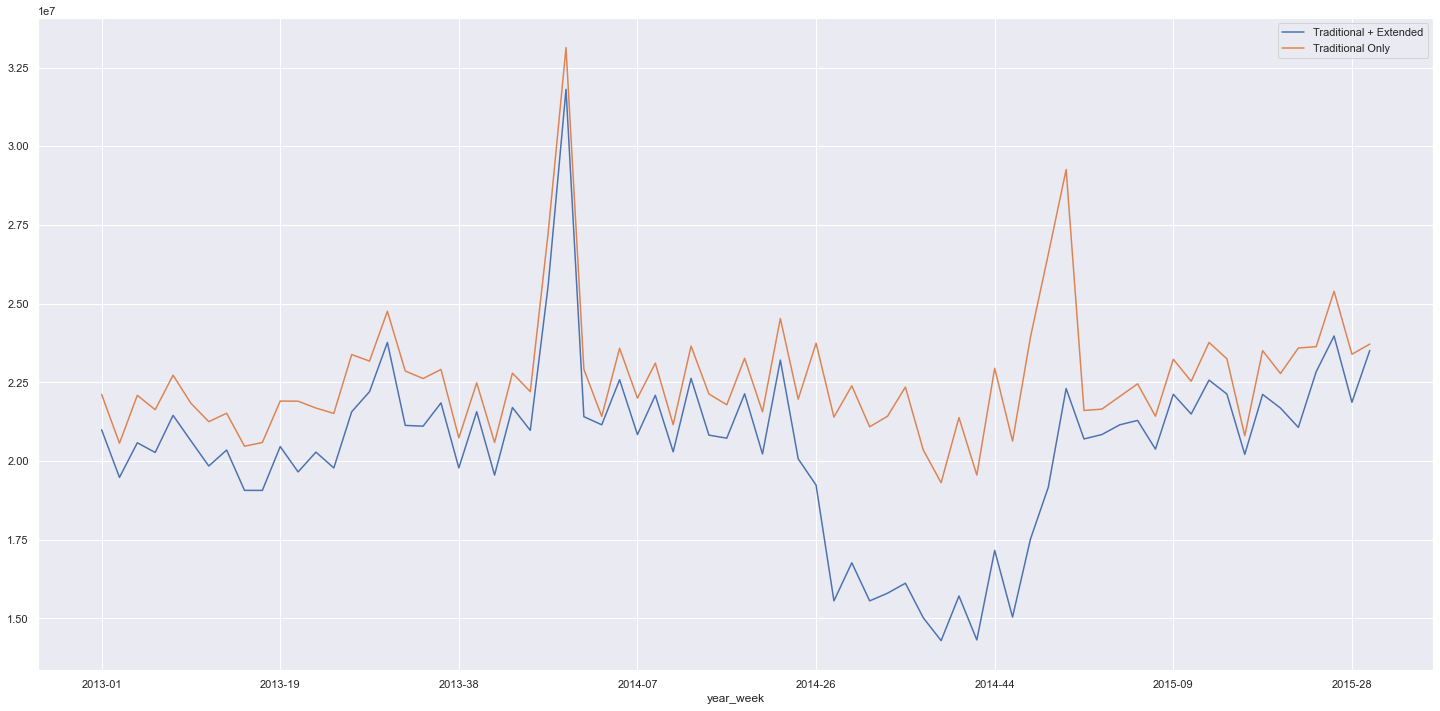

In [46]:
ax = df4[( df4[ 'promo' ] == 1 ) & ( df4[ 'promo2' ] == 1 )][ [ 'year_week', 'sales' ] ].groupby( 'year_week' ).sum().plot()

df4[( df4[ 'promo' ] == 1 ) & ( df4[ 'promo2' ] == 0 )][ [ 'year_week', 'sales' ] ].groupby( 'year_week' ).sum().plot( ax = ax )

ax.legend( labels = [ 'Traditional + Extended', 'Traditional Only'])


### **H7.** Stores open on Christmas Holiday should sell more.
**FALSE** - Stores sell less on Christmas comparing to other holidays and ordinary days.

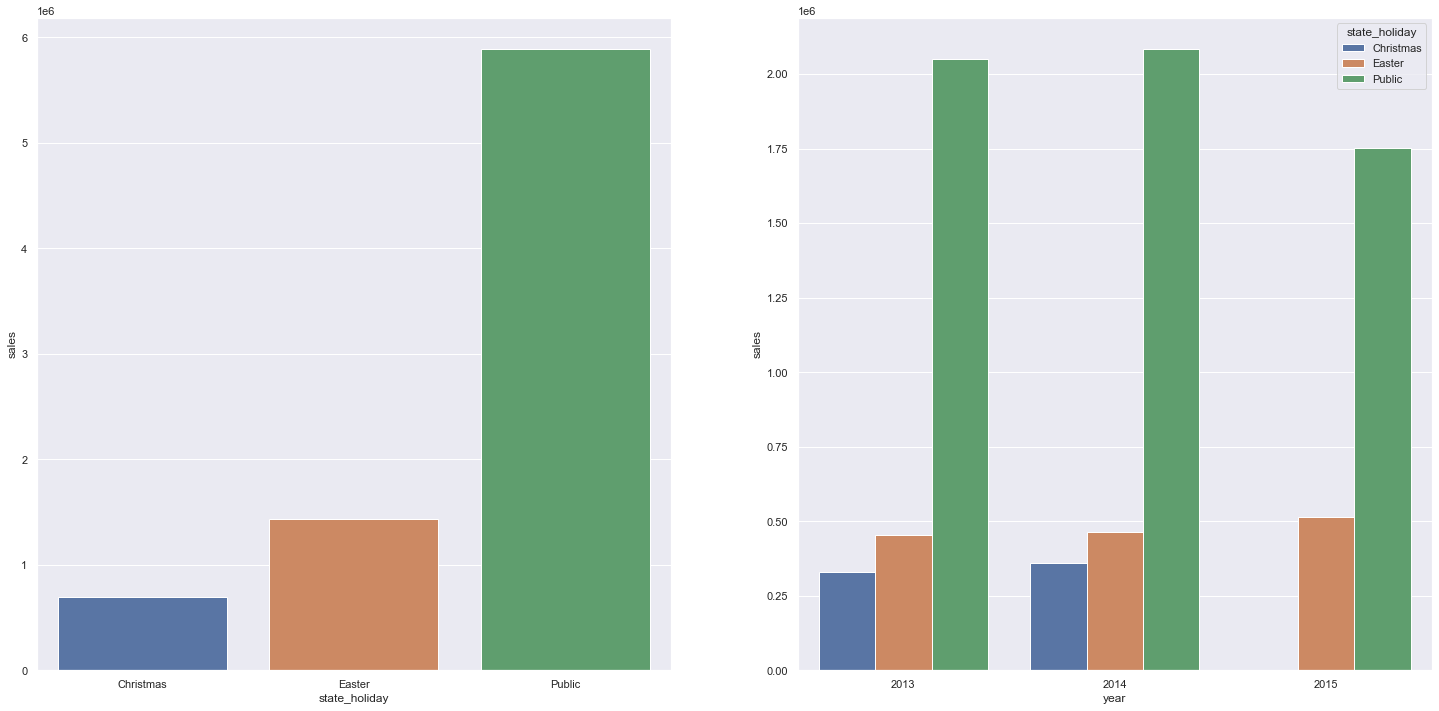

In [47]:
aux1 = df4[ df4[ 'state_holiday' ] != 'None']
aux2 = aux1[ [ 'state_holiday', 'sales' ] ].groupby( 'state_holiday' ).sum().reset_index()

subplot( 1, 2, 1 )
sns.barplot( x = 'state_holiday', y = 'sales', data = aux2 );

aux3 = aux1[ [ 'state_holiday', 'sales', 'year' ] ].groupby( ['state_holiday', 'year'] ).sum().reset_index()

subplot( 1, 2, 2 )
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = aux3 );

### **H8.** Stores should sell more over the years.
**FALSE** - Sales have dropped as the years go by.

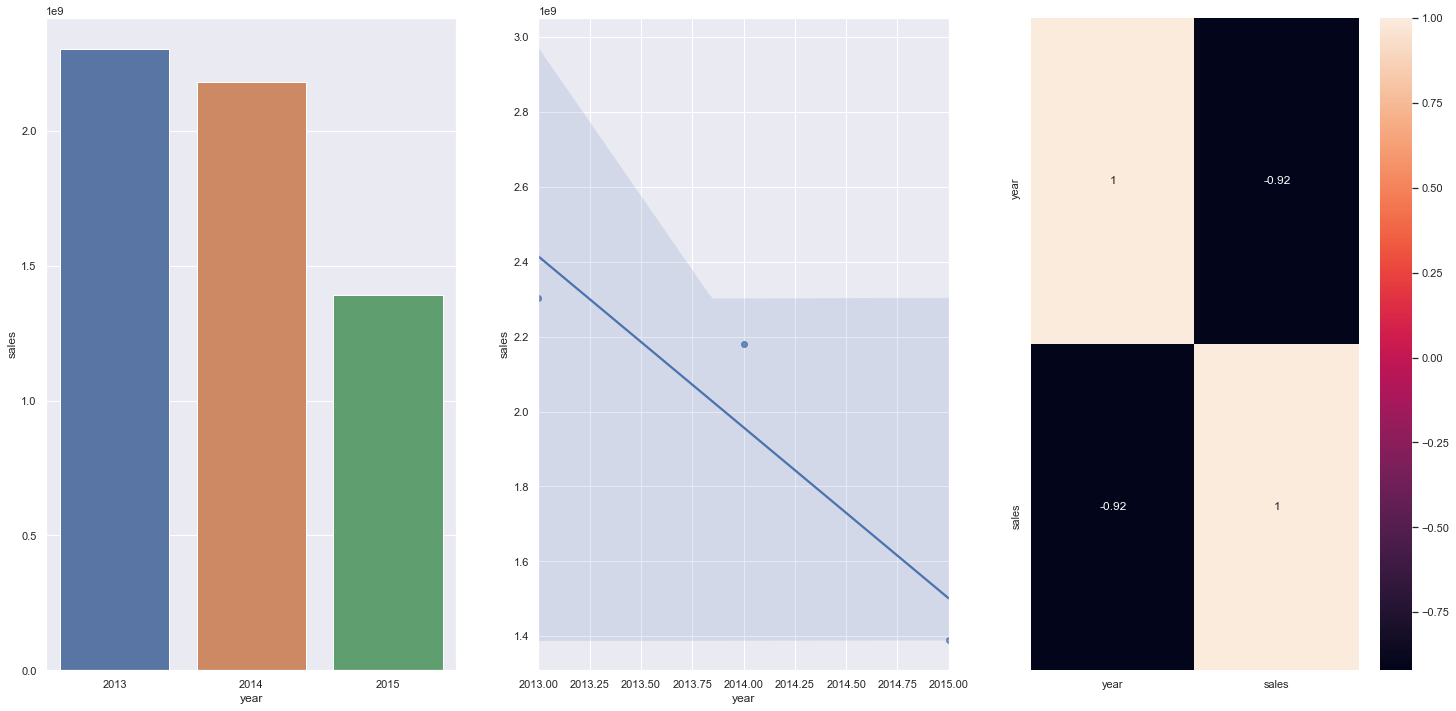

In [48]:
aux1 = df4[ ['year', 'sales' ] ].groupby('year').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x = 'year', y = 'sales', data = aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x = 'year', y = 'sales', data = aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr ( method = 'pearson' ), annot = True);

### **H9.** Stores should sell more in the second semester of each year.
**FALSE** -  Stores sell less in the second semester of each year.

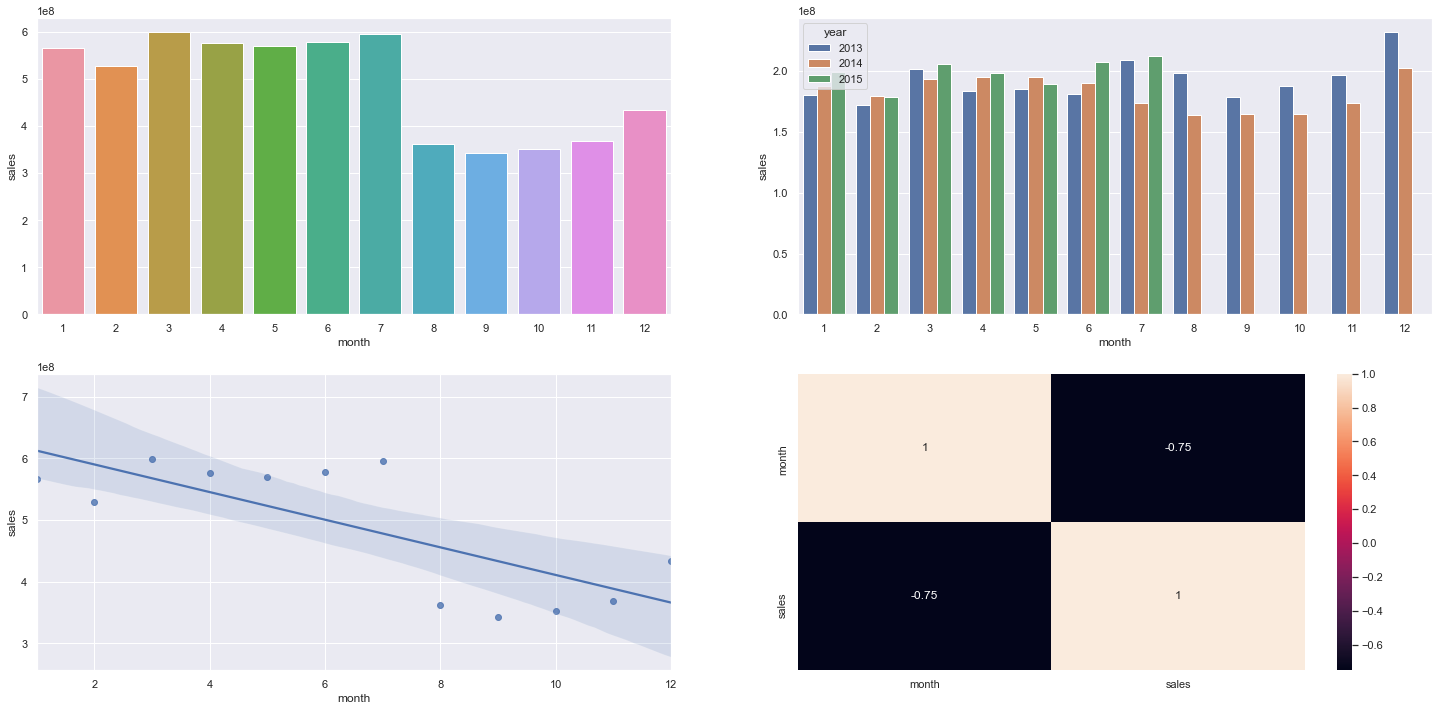

In [49]:
plt.subplot( 2, 2, 1 )
aux1 = df4[ [ 'month', 'sales' ] ].groupby( 'month' ).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', data = aux1);

plt.subplot( 2, 2, 2 )
aux2 = df4[ [ 'month', 'year', 'sales' ] ].groupby( [ 'month', 'year' ] ).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', hue = 'year', data = aux2 );

plt.subplot( 2, 2, 3 )
sns.regplot( x = 'month', y = 'sales', data = aux1);

plt.subplot( 2, 2, 4 )
sns.heatmap( aux1.corr( method = 'pearson' ), annot = True );

### **H10.** Stores should sell more after the 10th day of each month.
**TRUE** - Stores indeed sell more after the 10th day of each month.

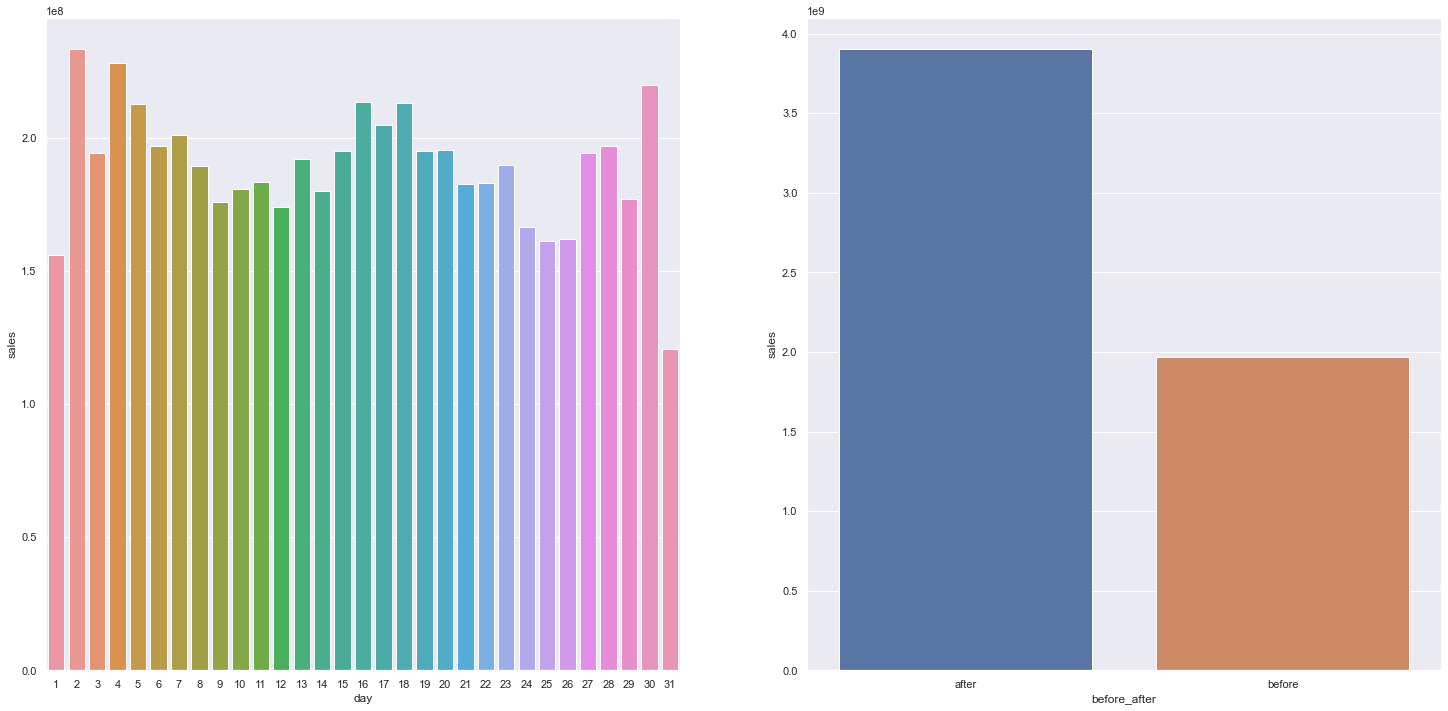

In [50]:
plt.subplot( 1, 2, 1 )
aux1 = df4[ ['day', 'sales' ] ].groupby('day').sum().reset_index()
sns.barplot( x = 'day', y = 'sales', data = aux1);

plt.subplot( 1, 2, 2)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before' if x <= 10 else 'after')
aux2 = aux1[ ['before_after', 'sales' ] ].groupby('before_after').sum().reset_index()
sns.barplot( x = 'before_after', y = 'sales', data = aux2);

### **H11.** Stores should sell less on weekends.
**TRUE** - Stores indeed sell less on weekends.

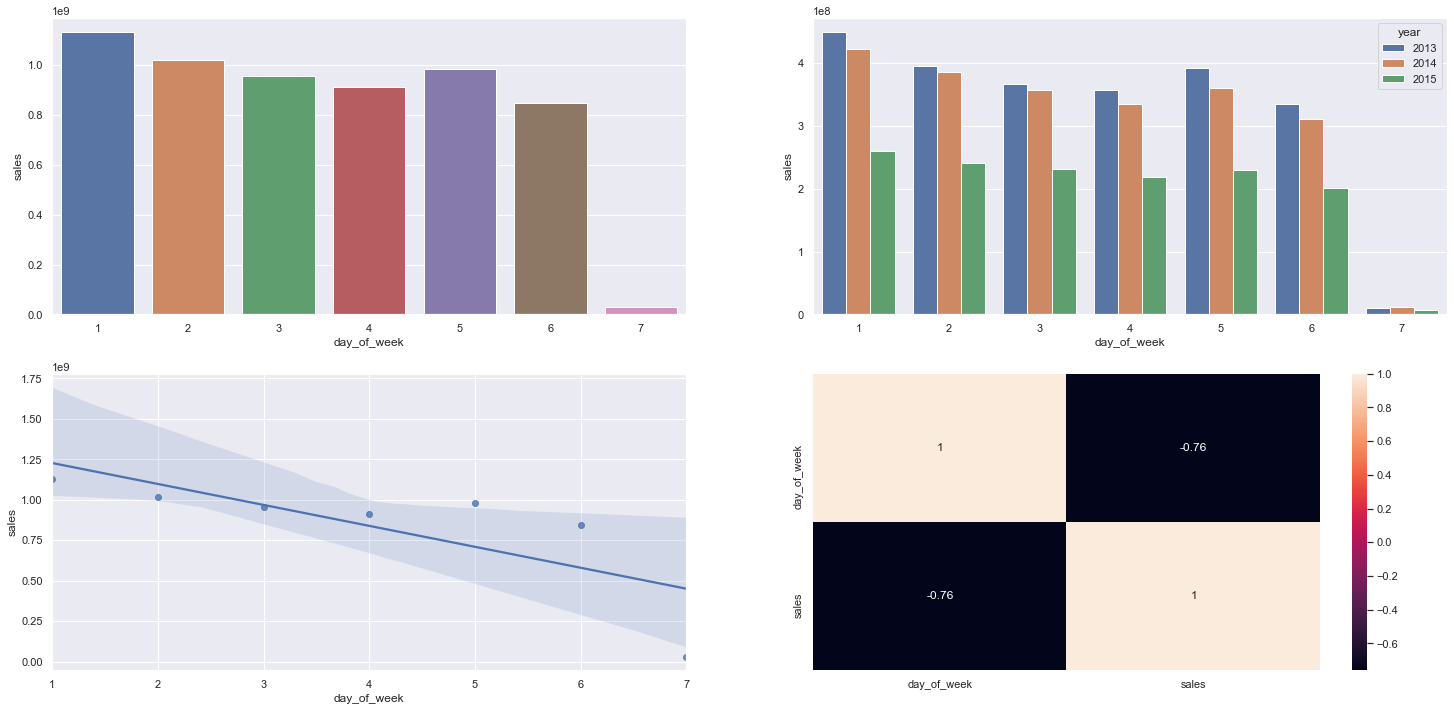

In [51]:
plt.subplot( 2, 2, 1 )
aux1 = df4[ ['day_of_week', 'sales' ] ].groupby( 'day_of_week' ).sum().reset_index()
sns.barplot( x = 'day_of_week', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 2 )
aux2 = df4[ ['day_of_week', 'year', 'sales' ] ].groupby( ['day_of_week', 'year'] ).sum().reset_index()
sns.barplot( x = 'day_of_week', y = 'sales', hue = 'year', data = aux2 );

plt.subplot( 2, 2, 3 )
sns.regplot( x = 'day_of_week', y = 'sales', data = aux1 );

plt.subplot( 2, 2, 4 )
sns.heatmap( aux1.corr( method = 'pearson' ) , annot = True );




### **H12.** Stores should sell less on school holidays.
**TRUE** - Stores indeed sell less on school holidays. (exception: August)

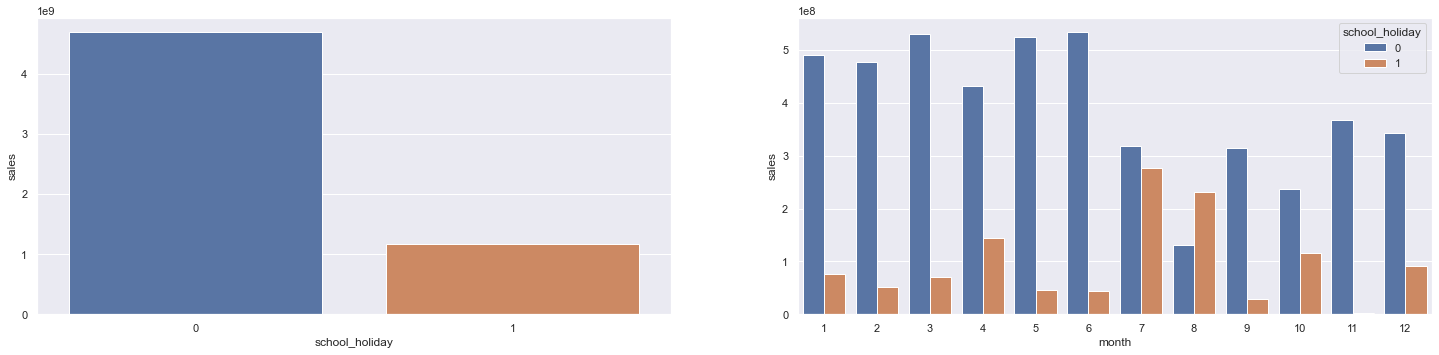

In [52]:
plt.subplot( 2, 2, 1 )
aux1 = df4[ ['school_holiday', 'sales' ] ].groupby( 'school_holiday' ).sum().reset_index()
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot( 2, 2, 2 )
aux2 = df4[ ['school_holiday', 'month', 'sales' ] ].groupby( ['school_holiday', 'month'] ).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);


### 4.2.1 Bivariate Analysis Overview

In [53]:
tab = [ [ 'Hipothesis', 'Status', 'Importance'],
      ['H1', 'False', 'Low'],
      ['H2', 'False', 'Medium'],
      ['H3', 'False', 'Medium'],
      ['H4', 'False', 'Low'],
      ['H5', '-', '-'],
      ['H6', 'False', 'Low'],
      ['H7', 'False', 'Medium'],
      ['H8', 'False', 'High'],
      ['H9', 'False', 'High'],
      ['H10', 'True', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'Low'],
            ]

print ( tabulate( tab , headers = 'firstrow') )

Hipothesis    Status    Importance
------------  --------  ------------
H1            False     Low
H2            False     Medium
H3            False     Medium
H4            False     Low
H5            -         -
H6            False     Low
H7            False     Medium
H8            False     High
H9            False     High
H10           True      High
H11           True      High
H12           True      Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Features

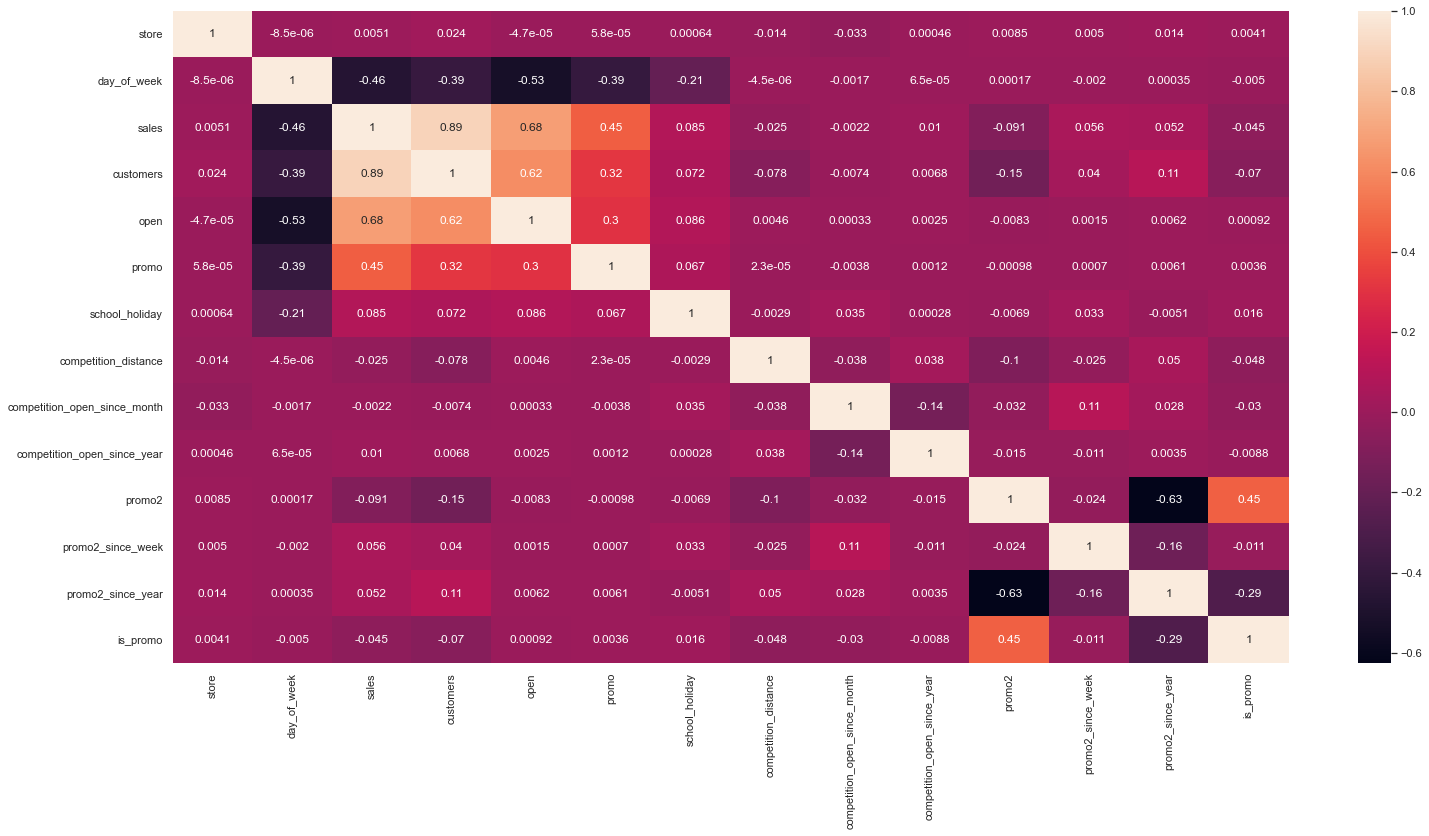

In [54]:
sns.heatmap( num_att.corr( method = 'pearson') , annot = True );

### 4.3.2 Categorical Features

In [55]:
a = df4.select_dtypes( object )

In [56]:
a.head()

,state_holiday,store_type,assortment,year_week
0,None,c,basic,2015-30
1,None,a,basic,2015-30
2,None,a,basic,2015-30
3,None,c,extended,2015-30
4,None,a,basic,2015-30


In [57]:
cramer(a['state_holiday'], a['store_type'])

0.071039693758565

<AxesSubplot:>

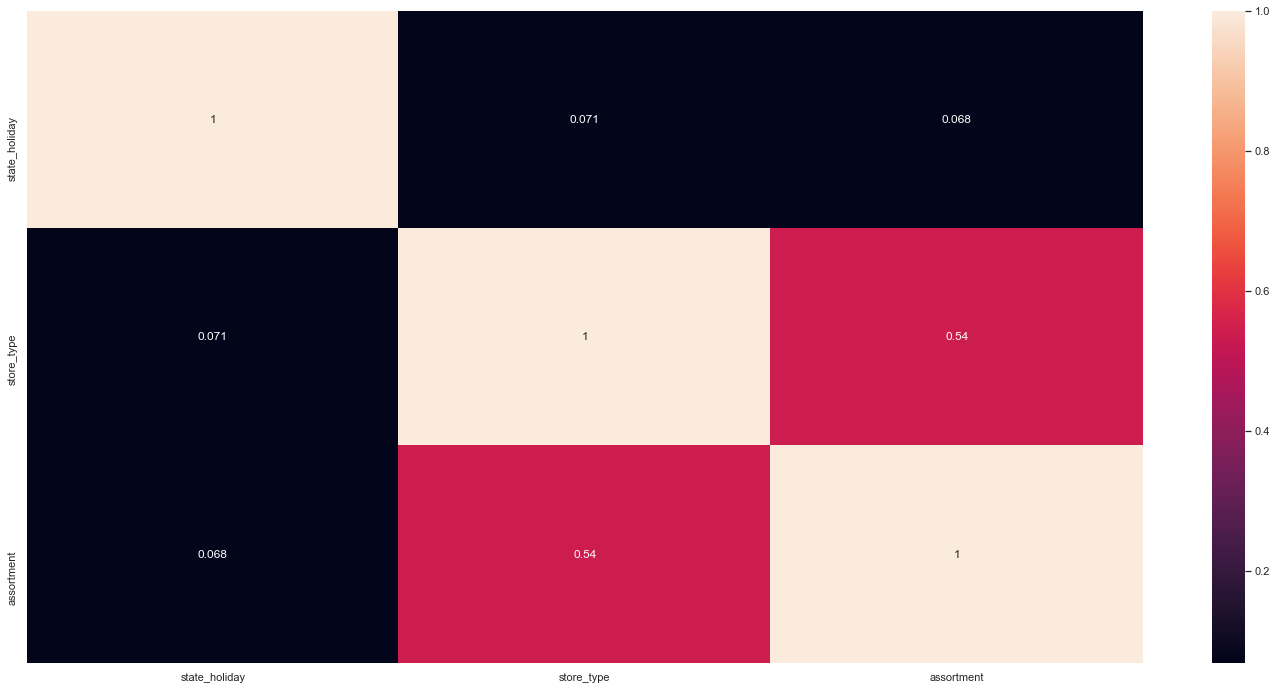

In [58]:
c1 = cramer(a['state_holiday'], a['state_holiday'])
c2 = cramer(a['state_holiday'], a['store_type'])
c3 = cramer(a['state_holiday'], a['assortment'])
c4 = cramer(a['store_type'], a['state_holiday'])
c5 = cramer(a['store_type'], a['store_type'])
c6 = cramer(a['store_type'], a['assortment'])
c7 = cramer(a['assortment'], a['state_holiday'])
c8 = cramer(a['assortment'], a['store_type'])
c9 = cramer(a['assortment'], a['assortment'])

m = pd.DataFrame( { 'state_holiday': [c1, c2, c3], 'store_type': [c4, c5, c6], 'assortment': [c7, c8, c9] } )

m = m.set_index( m.columns )

sns.heatmap( m, annot = True)

# 5.0 STEP 05 - DATA PREPARATION

In [59]:
df5 = df4.copy()

## 5.1 - Standardization

From 4.1.2 (numerical features univariate analysis) it is noticeable that no features are normally distributed. Therefore no standardization technique will be applied.

## 5.2 - Rescaling

In [60]:
rs = RobustScaler()
mms = MinMaxScaler()


#competition_distance #robust
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameters\competition_distance_scaler.pkl', 'wb' ) )

#year #mms
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameters\year_scaler.pkl', 'wb' ) )

#competition_time_month #robust
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameters\competition_time_month_scaler.pkl', 'wb' ) )

#promo_time_week #mms
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open( 'parameters\promo_time_week_scaler.pkl', 'wb' ) )

## 5.3 - Transformation

### 5.3.1 Encoding

In [61]:
#state_holiday - one hot encoding
df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns = ['state_holiday'] )

#store_type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'])
pickle.dump( le, open( 'parameters\store_type_scaler.pkl', 'wb' ) )


#assortment - ordinal encoding
a_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
df5['assortment'] = df5['assortment'].map(a_dict)


### 5.3.2 Target feature encoding

In [62]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Naturally cyclical features transformation

In [63]:
#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x*2*np.pi/7 ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x*2*np.pi/7 ) )

#month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x*2*np.pi/12 ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x*2*np.pi/12 ) )

#day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x*2*np.pi/30 ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x*2*np.pi/30 ) )

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x*2*np.pi/52 ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x*2*np.pi/52 ) )

# 6.0 STEP 06 - FEATURE SELECTION

In [64]:
df6 = df5.copy()

## 6.1 Train and validation data split

In [65]:
#idea - validation: last 6 weeks of data. Train: all data except those last 6 weeks

#dropping features that were transformed into new features:

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'competition_since', 'year_week', 'promo_since']

df6 = df6.drop( cols_drop, axis = 1 )

In [66]:
df6[['store', 'date']].groupby('store').max().reset_index()

max_date = df6['date'].max()
lim_date = max_date - datetime.timedelta(days = 6*7) 

X_train = df6[df6['date'] < lim_date]
y_train = X_train['sales']

X_test = df6[df6['date'] >= lim_date]
y_test = X_test['sales']

## 6.2 Applying Boruta

In [67]:
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
y_train_n = y_train.values

#commenting Boruta so it won't run next time we open this notebook
#rf = RandomForestRegressor( n_jobs = 1)

#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( X_train_n, y_train_n)

In [68]:
#cols_selected = boruta.support_.tolist()

X_train_fs = X_train.drop(['sales', 'date'], axis = 1 )

#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#cols_not_selected_boruta = np.setdiff1d( X_train_fs.columns, cols_selected_boruta )



## 6.3 Manual feature selection

In [69]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',                       
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

features_to_add = ['sales', 'date']

#final_features

cols_selected_boruta_full = cols_selected_boruta.copy()

cols_selected_boruta_full.extend( features_to_add )

# 7.0 STEP 07 - MACHINE LEARNING MODELS

In [70]:
df7 = df6.copy()

In [71]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

x_training = X_train[ cols_selected_boruta_full]

## 7.1 Average model

In [72]:
# model
#aux1 = x_test.copy()
#aux1['sales'] = y_test.copy()

# prediction
#aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'prediction'})

#aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')

#y_hat_mean = aux1['prediction']


# performance

#baseline_result = ml_error( 'average model', np.expm1(y_test) , np.expm1(y_hat_mean) )
#baseline_result

## 7.2 Linear Regression

In [73]:
# model
#lr = LinearRegression().fit( x_train, y_train )

# prediction
#y_hat_lr = lr.predict( x_test )

# performance

#lr_result = ml_error( 'Linear Regression', np.expm1(y_test) , np.expm1(y_hat_lr) )
#lr_result

## 7.3 Regularized Linear Regression (Lasso)

In [74]:
# model
#lrr = Lasso( alpha = 0.01 ).fit( x_train, y_train )

# prediction
#y_hat_lrr = lrr.predict( x_test )

# performance

#lrr_result = ml_error( 'Regularized Linear Regression', np.expm1(y_test) , np.expm1(y_hat_lrr) )
#lrr_result

## 7.4 Random Forest Regressor

In [75]:
# model
#rf = RandomForestRegressor( n_estimators = 100, n_jobs = -1, random_state = 42 ).fit( x_train, y_train )

# prediction
#y_hat_rf = rf.predict( x_test )

# performance

#rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test) , np.expm1(y_hat_rf) )
#rf_result

## 7.5 XGBoost Regressor

In [76]:
# model
#xgb_model = xgb.XGBRegressor( objective = 'reg:squarederror', 
#                             n_estimators = 100, n_jobs = -1, random_state = 42  ).fit( x_train, y_train )

# prediction
#y_hat_xgb = xgb_model.predict( x_test )

# performance

#xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test) , np.expm1(y_hat_xgb) )
#xgb_result

## 7.6 Model comparison

In [77]:
#results = pd.concat( [ baseline_result, lr_result, lrr_result, rf_result, xgb_result ] )
#results.sort_values( 'RMSE' )

### 7.6.1 Model comparison - Cross Validation

In [78]:
#lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr)
#lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True)
#xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', xgb_model, verbose = True)

In [79]:
#results_cv = pd.concat( [ lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv ] )

In [80]:
#print(results_cv.sort_values(by = 'RMSE CV'))

Best performing model: **Random Forest**

# 8.0 STEP 08 - HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [81]:
param = { 'n_estimators': [ 50, 100, 150, 200], 
          'max_features': ['auto', 'sqrt'],
          'max_depth': [15, 30, 45, 60, 75, 90, 105, 120],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'bootstrap': [True, False] }

MAX_EVAL = 6

In [82]:
#import random

#final_result_rf = pd.DataFrame()

#for i in range( MAX_EVAL):
#    hp = {kf: random.sample(v, 1 )[0] for kf, v in param.items() }
#    print(hp)
    # model
#    rf_model = RandomForestRegressor( n_estimators = hp['n_estimators'], 
#                                 max_features = hp['max_features'], 
#                                 max_depth = hp['max_depth'], 
#                                 min_samples_split = hp['min_samples_split'],
#                                 min_samples_leaf = hp['min_samples_leaf'],
#                                 bootstrap = hp['bootstrap'] )

    # performance

#    rf_result = cross_validation(x_training, 5, 'Random Forest Regressor', rf_model, verbose = True)
#    final_result_rf = pd.concat([final_result_rf, rf_result])
#final_result_rf

In [83]:
best_param = {'n_estimators': 50, 'max_features': 'sqrt', 'max_depth': 120, 'min_samples_split': 10, 'min_samples_leaf': 2, 'bootstrap': False}

## 8.2 Final Model

In [84]:
# final model
rf_model_tuned = RandomForestRegressor( n_estimators = best_param['n_estimators'], 
                                 max_features = best_param['max_features'], 
                                 max_depth = best_param['max_depth'], 
                                 min_samples_split = best_param['min_samples_split'],
                                 min_samples_leaf = best_param['min_samples_leaf'],
                                 bootstrap = best_param['bootstrap'] )

# prediction
#y_hat_xgb_tuned = xgb_model_tuned.predict( x_test )

# performance

#xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test) , np.expm1(y_hat_xgb_tuned) )
#xgb_result_tuned = pd.DataFrame( {'Model': 'XGBoost Regressor', 'MAE': 735.949309, 'MAPE': 11.178333, 'RMSE': 1083.727583 }, index = [0] )
#xgb_result_tuned

In [85]:
#pickle.dump( rf_model_tuned, open( 'model\model_rossmann.pkl', 'wb') )

In [86]:
rf_model_tuned = pickle.load( open ('model\model_rossmann.pkl', 'rb' ) )

In [87]:
#final train
rf_model_tuned.fit(x_train, y_train)

LinearRegression()

In [88]:
#final performance
#rf_final_result = ml_error( 'Random Forest Regressor', np.expm1(y_test) , np.expm1(yhat_rf_tuned) )
#rf_final_result = pd.DataFrame( {'Modelo': 'XGBoost Regressor', 'MAE': 509.322508, 'MAPE': 76194986, 'RMSE': 846.988842 }, index = [0] )
#rf_final_result

# 9.0 STEP 09 - Metrics Comprehension

## 9.1 Business Performance

In [89]:
#final prediction
yhat_rf_tuned = rf_model_tuned.predict(x_test)

In [90]:
df9 = X_test[cols_selected_boruta_full].copy()

In [91]:
df9['sales'] = df9['sales'].apply( lambda x: np.expm1( x ) )
df9['predictions'] = np.expm1( yhat_rf_tuned )

df9_aux3 = df9[['store','predictions']].groupby('store').sum().reset_index()

df9_aux3.head()

#MAE and MAPE
df9_aux4 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns = {0 : 'MAE'} )
df9_aux5 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns = {0 : 'MAPE'} )
df9_aux6 = df9[['store', 'sales']].groupby('store').sum().reset_index()


df9_bus = pd.merge(df9_aux4, df9_aux5, how = 'inner', on = 'store')
df9_bus = pd.merge(df9_bus, df9_aux3, how = 'inner', on = 'store')
df9_bus = pd.merge(df9_bus, df9_aux6, how = 'inner', on = 'store')

#Scenarios
df9_bus['worst_scenario'] = df9_bus['predictions']-df9_bus['MAE']
df9_bus['best_scenario'] = df9_bus['predictions']+df9_bus['MAE']

#ordering columns
df9_bus = df9_bus[ [ 'store', 'sales', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE' ] ]

In [92]:
rf_final_result = ml_error( 'Random Forest Regressor', np.expm1(y_test) , np.expm1(yhat_rf_tuned) )
rf_final_result

,Model,MAE,MAPE,RMSE
0,Random Forest Regressor,1867.089774,29.269403,2671.049215


<AxesSubplot:xlabel='store', ylabel='MAPE'>

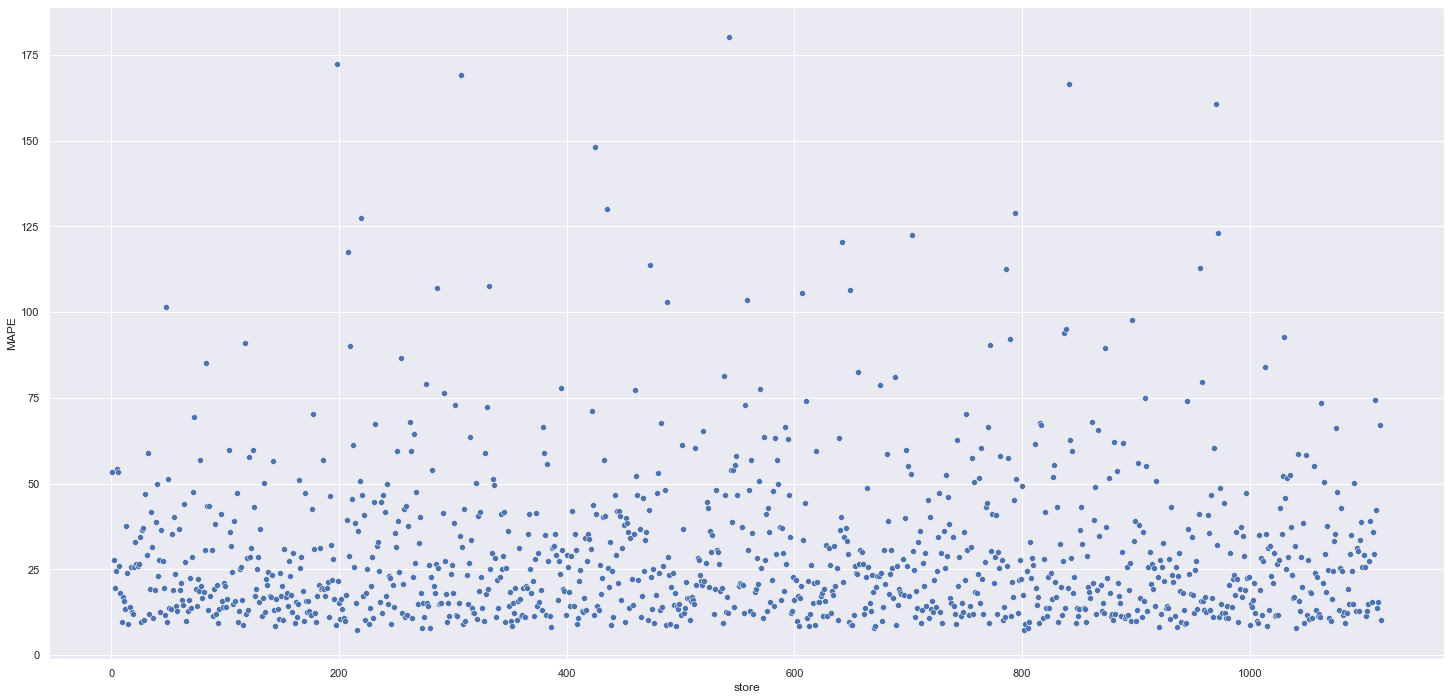

In [93]:
sns.scatterplot( x = 'store', y = 'MAPE', data = df9_bus )

## 9.2 Sales Performance

In [94]:
df9_total = df9_bus[['predictions', 'worst_scenario', 'best_scenario'] ].apply( lambda x: np.sum(x), axis = 0 ).reset_index().rename( columns = {'index': 'Scenario', 0: 'Values'})
df9_total['Values'] = df9_total['Values'].map( 'R$ {:,.2f}'.format ) 
df9_total

,Scenario,Values
0,predictions,"R$ 274,988,451.87"
1,worst_scenario,"R$ 272,909,258.41"
2,best_scenario,"R$ 277,067,645.33"


## 9.3 Machine Learning Performance

In [95]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

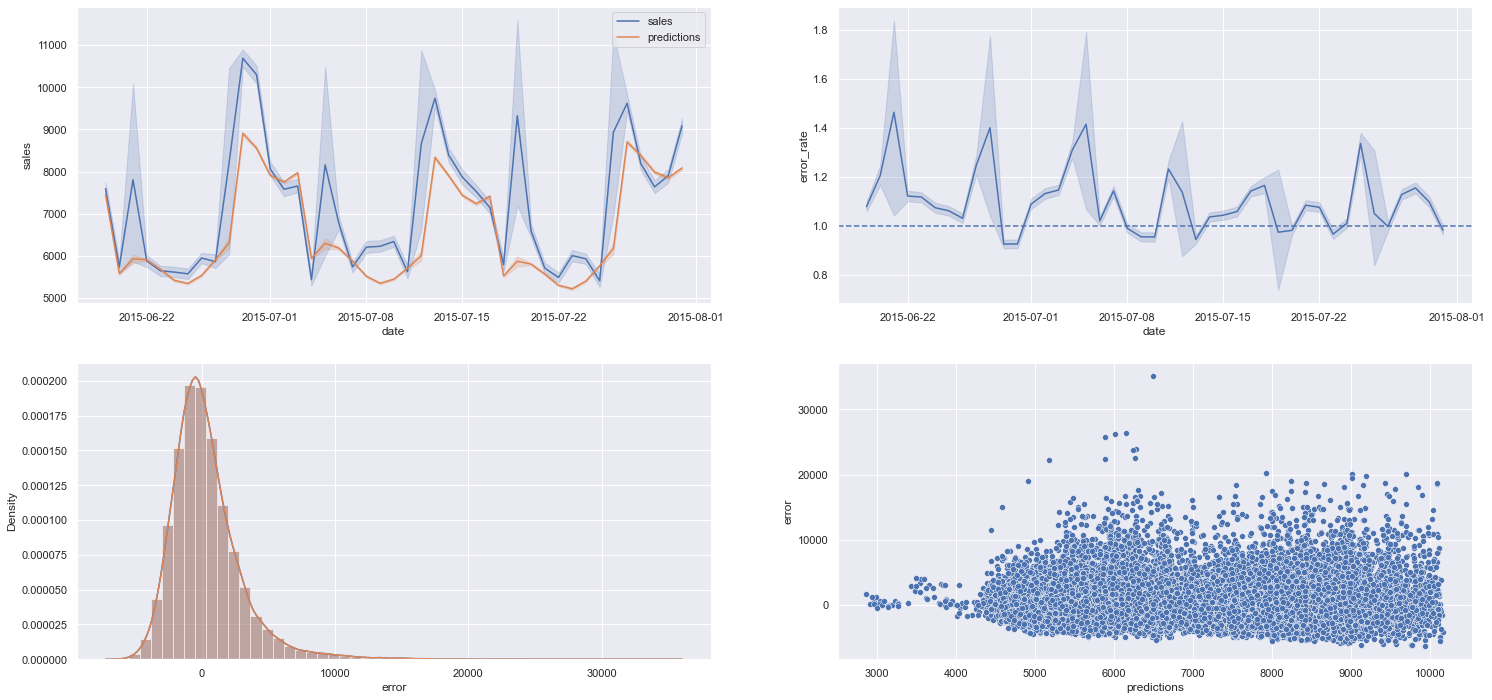

In [96]:
plt.subplot( 2, 2, 1)
sns.lineplot( x = 'date', y = 'sales', data = df9, label = 'sales');
sns.lineplot( x = 'date', y = 'predictions', data = df9, label = 'predictions');

plt.subplot( 2, 2, 2)
sns.lineplot( x = 'date', y = 'error_rate', data = df9);
plt.axhline( 1, ls = '--' );

plt.subplot( 2, 2, 3)
sns.distplot( df9['error'] );

plt.subplot( 2, 2, 3)
sns.distplot( df9['error'] );

plt.subplot( 2, 2, 4)
sns.scatterplot( x = 'predictions', y = 'error', data = df9 );

# 10.0 STEP 10 - MODEL DEPLOYMENT INTO PRODUCTION

## 10.1 - Rossmann Class

In [97]:
rf_model_tuned = pickle.load( open ('model\model_rossmann.pkl', 'rb' ) )

In [98]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path = 'D:\Data Science\Comunidade DS\DataScience_Em_Producao\meus notebooks'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + '\parameters\competition_distance_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( self.home_path + '\parameters\year_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + '\parameters\competition_time_month_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + '\parameters\promo_time_week_scaler.pkl', 'rb' ) )
        self.store_type_scaler             = pickle.load( open( self.home_path + '\parameters\store_type_scaler.pkl', 'rb' ) )
    
    def data_cleaning( self, df1):

        #df1 = df_raw.copy()

        ## 1.1 Column renaming

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date']) 

        ## 1.5 Filling NAs

        #competition_distance:
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan(x) else x)

        #competition_open_since_month and competition_open_since_year:
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'] , axis = 1) 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'] , axis = 1) 

        #promo2_since_week and promo2_since_year:
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'] , axis = 1) 
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'] , axis = 1) 

        #promo_interval: 
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'].fillna(0, inplace = True)
        df1['month_map'] = df1['date'].dt.month.map( month_map)
        df1['is_promo'] = df1.apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'] else 0, axis = 1 )


        ## 1.6  Checking Data Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype ( 'int64' )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype ( 'int64' )
        df1['promo2_since_week'] = df1['promo2_since_week'].astype ( 'int64' )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype ( 'int64' )
        
        return df1

    
    def feature_engineering( self, df2 ):
    
        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since - creating competition_time_month: amount of months since competition started
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( 'int64' )

        # promo since - creating promo_time_week: amount of weeks since promotion started.
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( 'int64' )

        #assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'Public' if x == 'a' else 'Easter' if x == 'b' else 'Christmas' if x == 'c' else 'None' )


        # 3.0 - FEATURE FILTERING

        ## 3.1 Row selection
        df2 = df2[ df2['open'] != 0 ]

        ## 3.2 Column selection
        cols_drop = [ 'open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis = 1 )    
        
        return df2
    
    
    def data_preparation( self, df5 ):

        #competition_distance #robust
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        
        #year #mms
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
        
        #competition_time_month #robust
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        
        #promo_time_week #mms
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
       
        ## 5.3 - Transfation

        ### 5.3.1 Encoding

        #state_holiday - one hot encoding
        df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns = ['state_holiday'] )

        #store_type - label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'])
        
        #assortment - ordinal encoding
        a_dict = {'basic' : 1, 'extra' : 2, 'extended' : 3}
        df5['assortment'] = df5['assortment'].map(a_dict)


        ### 5.3.3 Transforming naturally cyclical features

        #day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x*2*np.pi/7 ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x*2*np.pi/7 ) )

        #month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x*2*np.pi/12 ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x*2*np.pi/12 ) )

        #day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x*2*np.pi/30 ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x*2*np.pi/30 ) )

        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x*2*np.pi/52 ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x*2*np.pi/52 ) )
        
        
    
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
             'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',                       
             'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data):
        
        #prediction
        pred = model.predict( test_data )
        
        #merging prediction to original dataframe
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient = 'records', date_format = 'iso')
        

## 10.2 - API Handler

In [99]:
import pickle
from flask import Flask, request, Response
import pandas as pd

from rossmann.Rossmann import Rossmann

#loading model
model = pickle.load( open( 'D:\Data Science\Comunidade DS\DataScience_Em_Producao\meus notebooks\model\model_rossmann.pkl', 'rb' ) )


#API inicialization
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods = ['POST'] )

def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): #single example
            test_raw = pd.DataFrame( test_json, index = [0] )
            
        else:  #multiple example   
            test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
            
        # instantiate rossmann class
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        #feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        #data preparation
        df3 = pipeline.data_preparation( df2 )
        
        #prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
            
    else: # no data
        return Response( '{}', status = 200, mimetype = 'application/json')

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3 - API Tester

In [ ]:
import json
import requests

In [ ]:
#loading test dataset
df10 = pd.read_csv( 'data/test.csv' )

In [ ]:
df_test = pd.merge( df10, df_store_raw, how = 'left', on = 'Store' )

df_test = df_test[ df_test[ 'Store' ].isin( [ 24, 12, 22 ] ) ]

df_test = df_test[ df_test['Open'] != 0 ]
df_test = df_test[ ~df_test[ 'Open'].isnull() ]
df_test = df_test.drop('Id', axis = 1)

In [ ]:
data = json.dumps( df_test.to_dict( orient = 'records' ) )

In [ ]:
url = 'http://localhost:5000/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers = header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

In [ ]:
df2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

In [ ]:
for i in range( len( df2 ) ):
    print('Store number {} will sell ${:,.2f} in the next 6 weeks.'.format(
    df2.loc[i, 'store'],
    df2.loc[i, 'prediction'] ) )